# Cleaning up scores from the VQA study

## Step 1: Keeping only unique scores

A few subjects had crashes in their video player, due to which they had to rewatch 1-2 videos before which the crash occurred. The first score they provided is retained. 

In [1]:
import os
import numpy as np
import pandas as pd
import glob

def removeDuplicates(score_df):
    uniqueList = []
    unique_indices = []
    hash_names = score_df['hash_name']
    for index,elem in enumerate(hash_names): 
        if elem not in uniqueList:
            uniqueList.append(elem)
            unique_indices.append(index)
    unique_df = pd.DataFrame([score_df.iloc[i] for i in unique_indices])

    return unique_df

score_csv_list = glob.glob(os.path.join('./scores/','*_1.csv'))

for score_csv in score_csv_list:
    second_score_csv  = score_csv[:-6] +'_2.csv'
    #print(second_score_csv)

    subject_id = score_csv.split('_')[-2]
  #  print(subject_id)
    first_score_df = pd.read_csv(score_csv,header=0,names=['index','hash_name','score'])
    first_score_df['index']=np.arange(len(first_score_df))
    
    # we record whether the score was taken in the first session or not so that session-wise z scores can be calculated 
    first_score_df['first_session'] = [True]*len(first_score_df)
    first_unique_score_df = removeDuplicates(first_score_df)
    if(os.path.exists(second_score_csv)==False):
        new_score_df = first_unique_score_df
        new_score_df.to_csv(os.path.join('sep_sess_unique_scores/',os.path.basename(score_csv)[:-6]+'.csv'))
        continue
    second_score_df = pd.read_csv(second_score_csv,header=0,names=['index','hash_name','score'])
    second_score_df['index']=np.arange(len(second_score_df))
    second_score_df['first_session'] = [False]*len(second_score_df)
    second_unique_score_df = removeDuplicates(second_score_df)
    new_score_df = pd.concat([first_score_df,second_score_df],ignore_index=True)
    new_score_df.to_csv(os.path.join('sep_sess_unique_scores/',os.path.basename(score_csv)[:-6]+'.csv'))
    #print(len(new_score_df))


## Step 2: Convert unique scores to Z scores

Z scores are computed on a per-session basis, i.e. subtract the mean of scores for that subject for that session from each score and divide by the standard deviation for that subject for that session.

In [4]:
hash_df = pd.read_csv('./hash_list.csv')
#print(hash_df)

hash_list = list(hash_df)

# certain subjects had both their sessions before the videos were corrected
group1_subject_ids= np.concatenate((np.arange(1,31),np.arange(91,96))) 


group2_bad_avc_sfr_subject_ids = [32,35,36,37,40]
group2_bad_avc_sfr_subject_ids_firstsess = [34,38,39,41]
    
score_csv_list = glob.glob(os.path.join('./sep_sess_unique_scores/','*.csv'))
for score_csv in score_csv_list:
    subject_num = int(os.path.splitext(os.path.basename(score_csv))[0].split('_')[1])
    orig_score_df = pd.read_csv(score_csv,header=0)#names=['index','hash_name','score'])
    score_df= orig_score_df.drop('index',axis=1)
    scores = np.asarray(score_df['score'],dtype=np.float32) 
    first_session = list(score_df['first_session'])
    vid_name = [hash_df[hash_df['hash_video_name']==hash_name].original_video_name.iloc[0] for hash_name in score_df['hash_name']]
    score_df['video']=vid_name
    
    # Drop AVC 
    if(subject_num in [1,4,7,8]):
        score_df= score_df[~(score_df['video'].str.contains('EPLDay') & score_df['video'].str.contains('AVC') \
                & score_df['video'].str.contains('HFR') & ~score_df['video'].str.contains('540p'))]
    elif(subject_num in [2,3,5,6]):
        score_df = score_df[~(score_df['video'].str.contains('EPLDay') & (score_df['first_session']==True) \
                &  score_df['video'].str.contains('AVC') & score_df['video'].str.contains('HFR') &  ~score_df['video'].str.contains('540p'))]
    if(subject_num in group1_subject_ids or subject_num in group2_bad_avc_sfr_subject_ids):
        score_df= score_df[~(score_df['video'].str.contains('EPLDay') & score_df['video'].str.contains('AVC') \
                & score_df['video'].str.contains('SFR') & ~score_df['video'].str.contains('540p'))]
    elif(subject_num in group2_bad_avc_sfr_subject_ids_firstsess):
        score_df = score_df[~(score_df['video'].str.contains('EPLDay') & (score_df['first_session']==True) \
                &  score_df['video'].str.contains('AVC') & score_df['video'].str.contains('SFR') &  ~score_df['video'].str.contains('540p'))]
    first_sess_scores = [scores[i] for i in range(len(score_df)) if (first_session[i]==True)]
    second_sess_scores = [scores[i] for i in range(len(score_df)) if (first_session[i]!=True) ]
    first_sess_zscores = (first_sess_scores-np.mean(first_sess_scores))/np.std(first_sess_scores)
    # ignore mean of empty slice warning. If a subject missed their second session that warning will pop up but won't affect anything
    second_sess_zscores = (second_sess_scores-np.mean(second_sess_scores))/np.std(second_sess_scores)
    zscores = 100*(np.concatenate((first_sess_zscores,second_sess_zscores))+3)/6
    score_df['raw_mos_zscore'] = zscores

    score_df.to_csv(os.path.join('./mos_sepsess_zscores',os.path.basename(score_csv)))


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:341

## Step 3: Remove outliers using the method recommended in ITU BT. 500 11

In [5]:
from scipy.stats import kurtosis
from collections import defaultdict


subj_csvs = glob.glob(os.path.join('./mos_sepsess_zscores/','*'))

video_dict = defaultdict(list)

for subject_csv in subj_csvs:
    subject_df = pd.read_csv(subject_csv)
    video_names = subject_df['video']
    for index,v in enumerate(video_names):
        score = 6*(subject_df['raw_mos_zscore'].iloc[index])/100 - 3
        vkey = os.path.splitext(v)[0]
        video_dict[vkey].append(score)


gauss_list = np.zeros(len(video_dict),dtype=bool)
all_vids = []
video_score_list = []
video_std_list = []

for ii,key_val in enumerate(video_dict.items()):
    key = key_val[0]
    val = key_val[1]
    print(len(val), ' subjects watched video ', key)
    all_vids.append(key)
    kurt = kurtosis(val,fisher=False)
#    print(kurt)
    if(kurt>=2 and kurt<=4):
        gauss_list[ii] = True
    video_score_list.append(np.mean(val))
    video_std_list.append(np.std(val))
#print(gauss_list)
gauss_score_std_dict = dict((z[0],list(z[1:])) for z in zip(all_vids,gauss_list,video_score_list,video_std_list)) 
#print(video_std_list)


reject = np.zeros(len(video_dict),dtype=bool)
for jj,subject_csv in enumerate(subj_csvs):
    p = 0
    q = 0
    subject_df = pd.read_csv(subject_csv)
    video_names = subject_df['video']
    for index,v in enumerate(video_names):
        score = 6*(subject_df['raw_mos_zscore'].iloc[index])/100 - 3
        vkey = os.path.splitext(v)[0]
        #print(score,video_dict[vkey][1],video_dict[vkey][2])
        if(gauss_score_std_dict[vkey][0] == True): 
            if(score >= video_dict[vkey][1]+2*video_dict[vkey][2]):
                p = p+1
            elif(score <= video_dict[vkey][1]-2*video_dict[vkey][2]):
                q=q+1
        else:
            if(score >= video_dict[vkey][1]+np.sqrt(20)*video_dict[vkey][2]):
                p = p+1
            elif(score <= video_dict[vkey][1]-np.sqrt(20)*video_dict[vkey][2]):
                q=q+1
    if(p==0 and q==0):
        continue
    else:
        print('Condition 1: ', (p+q)/len(subject_df))
        print('Condition 2: ', np.abs((p-q)/(p+q)))
#        print('two conditions above')
        if(((p+q)/len(subject_df))>0.05 and np.abs((p-q)/(p+q))<0.3):
            reject[jj]=True
            print('rejected ', subject_csv)
num_rej = np.sum(reject)
print(num_rej, ' subjects were rejected')

30  subjects watched video  USOpen_AVC_HFR_396p_600K_12
30  subjects watched video  Cricket1_AVC_HFR_288p_300K_198
30  subjects watched video  EPLDay_SRC_SRC_SRC_SRC_20
30  subjects watched video  Cricket1_HEVC_HFR_396p_900K_198
30  subjects watched video  TNFNFL_AVC_SFR_396p_800K_3184
30  subjects watched video  Cricket1_HEVC_SFR_720p_2200K_198
30  subjects watched video  EPLDay_HEVC_SFR_396p_600K_20
30  subjects watched video  Cricket1_HEVC_HFR_540p_1100K_198
30  subjects watched video  TNFNFL_AVC_SFR_720p_2000K_3184
30  subjects watched video  USOpen_SRC_SRC_SRC_SRC_12
30  subjects watched video  EPLDay_HEVC_SFR_396p_900K_20
30  subjects watched video  Cricket1_HEVC_HFR_288p_300K_198
23  subjects watched video  EPLDay_AVC_SFR_288p_200K_20
30  subjects watched video  USOpen_HEVC_SFR_288p_300K_12
30  subjects watched video  TNFF_HEVC_SFR_720p_2200K_32
30  subjects watched video  Cricket1_SRC_SRC_SRC_SRC_198
30  subjects watched video  TNFF_AVC_SFR_396p_800K_32
30  subjects watched vid

31  subjects watched video  Cricket1_SRC_SRC_SRC_SRC_86
31  subjects watched video  TNFF_AVC_SFR_396p_400K_16
30  subjects watched video  Cricket2_HEVC_SFR_288p_300K_90
30  subjects watched video  USOpen_AVC_HFR_720p_2200K_0
30  subjects watched video  EPLNight_AVC_SFR_540p_1200K_0
30  subjects watched video  USOpen_HEVC_HFR_288p_300K_0
31  subjects watched video  EPLNight_HEVC_SFR_720p_2200K_0
31  subjects watched video  EPLDay_HEVC_HFR_288p_300K_0
30  subjects watched video  TNFF_HEVC_SFR_720p_2200K_144
30  subjects watched video  USOpen_HEVC_HFR_540p_1100K_0
31  subjects watched video  TNFNFL_AVC_HFR_396p_600K_0
32  subjects watched video  TNFF_HEVC_HFR_288p_300K_144
31  subjects watched video  TNFF_AVC_HFR_288p_300K_16
30  subjects watched video  TNFF_HEVC_HFR_540p_1100K_144
30  subjects watched video  EPLNight_AVC_HFR_540p_1300K_0
30  subjects watched video  TNFF_HEVC_SFR_396p_600K_144
31  subjects watched video  USOpen_HEVC_SFR_540p_1900K_166
31  subjects watched video  TNFF_AVC_

29  subjects watched video  EPLNight_HEVC_HFR_540p_1900K_58
27  subjects watched video  USOpen_AVC_HFR_540p_1900K_604
29  subjects watched video  EPLNight_HEVC_HFR_288p_300K_58
27  subjects watched video  TNFNFL_HEVC_SFR_396p_600K_4211
27  subjects watched video  USOpen_HEVC_SFR_540p_1100K_604
27  subjects watched video  TNFNFL_AVC_HFR_720p_2200K_4211
27  subjects watched video  USOpen_HEVC_HFR_288p_300K_604
29  subjects watched video  Cricket2_SRC_SRC_SRC_SRC_210
27  subjects watched video  USOpen_HEVC_HFR_540p_1100K_604
27  subjects watched video  TNFNFL_HEVC_SFR_396p_900K_4211
29  subjects watched video  EPLNight_HEVC_SFR_540p_1100K_58
29  subjects watched video  Cricket1_HEVC_SFR_288p_300K_210
27  subjects watched video  TNFNFL_AVC_HFR_396p_600K_4211
29  subjects watched video  Cricket2_AVC_SFR_396p_400K_210
27  subjects watched video  TNFNFL_HEVC_HFR_396p_900K_4211
29  subjects watched video  EPLNight_HEVC_HFR_720p_2200K_58
27  subjects watched video  TNFNFL_HEVC_SFR_540p_1100K_42

## Step 4: Average scores for each video

In [27]:
scores = []
names = []
content = []
codec = []
fr = []
res = []
bitrate = [] 

for key,val in video_dict.items():
    scaled_val = 100*(np.asarray(val)+3)/6
    scores.append(np.mean(scaled_val))
    names.append(key)
    split_name = key.split('_')
    content.append(split_name[0]+'_'+split_name[-1])
    codec.append(split_name[1])
    fr.append(split_name[2])
    res.append(split_name[3])
    if(split_name[4]=='SRC'):
        bitrate.append(100000)
    else:
        bitrate.append(split_name[4][:-1])
#print([b for b in bitrate])
score_df = pd.DataFrame(list(zip(names,scores,content,codec,fr,res,bitrate)),columns=['video','mos','content','codec','fr','res','bitrate'])
score_df.to_csv('./lbvfr_sepsess_zscore_mos.csv')


## Step 5: Calculate DMOS from MOS

Here we calculate DMOS directly from MOS by subtracting the reference video's MOS from the distorted video's MOS. The other way to calculate DMOS is on a per-subject basis and then averaging the scores. The second approach is implemented in dmos_zscore_conversion.py. For this study, we will calculate DMOS from MOS.

In [28]:
copy_df = score_df.copy()
videos = list(score_df['video'])
mos=score_df['mos']

raw_dmos = []

for index,vid in enumerate(videos):
    vid_content = vid.split('_')[0]
    if('SRC' in vid):
        copy_df.drop(index,inplace=True)
#        print(len(copy_df))
        continue
    vid_time = vid.split('_')[-1]
    ref_vid = vid_content+'_SRC_SRC_SRC_SRC_'+vid_time
#    print(ref_vid)

    ref_score = score_df.iloc[videos.index(ref_vid)].mos
    vid_score = mos[index]
    raw_dmos.append(vid_score-ref_score)
copy_df['dmos'] = raw_dmos

copy_df.to_csv('./lbvfr_dmos_from_mos.csv')

## Analysis: Plot DMOS by different groupings

<IPython.core.display.Javascript object>


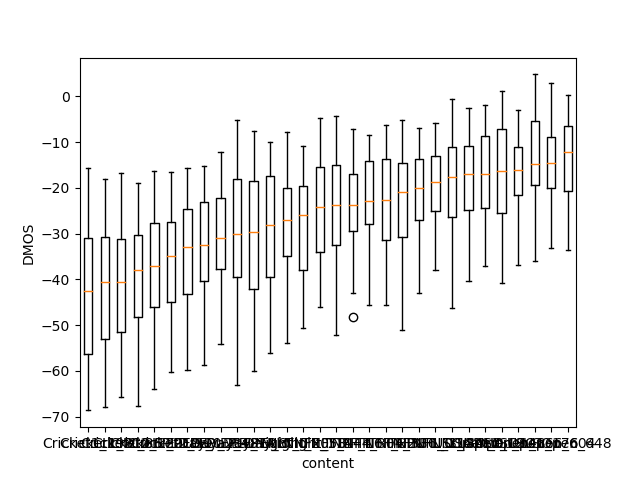

<IPython.core.display.Javascript object>


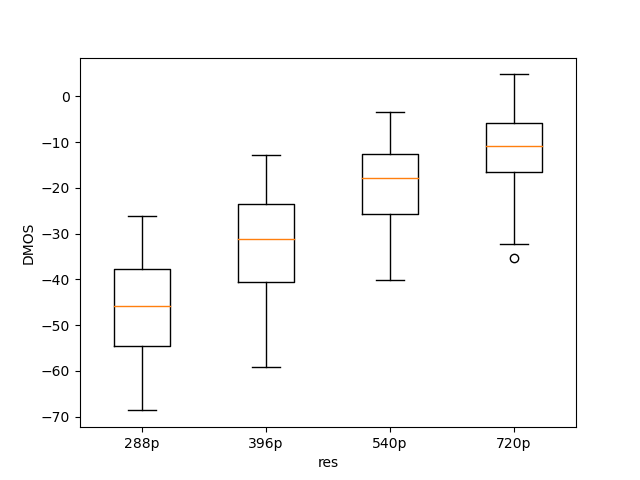

<IPython.core.display.Javascript object>


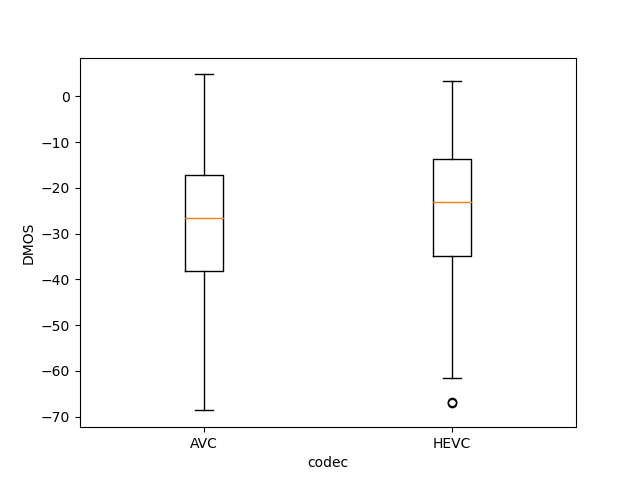

<IPython.core.display.Javascript object>


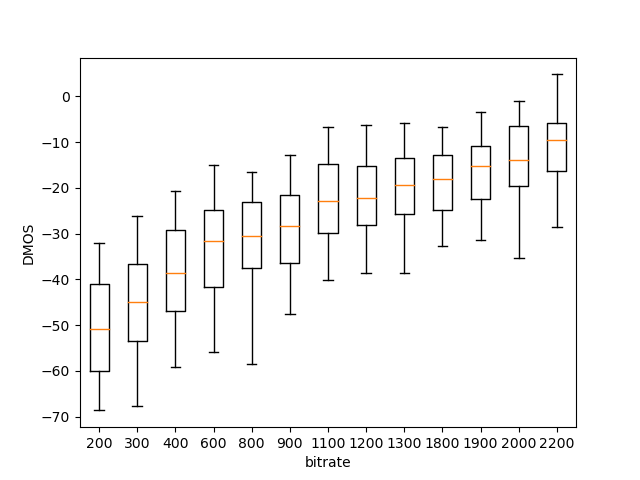

<IPython.core.display.Javascript object>


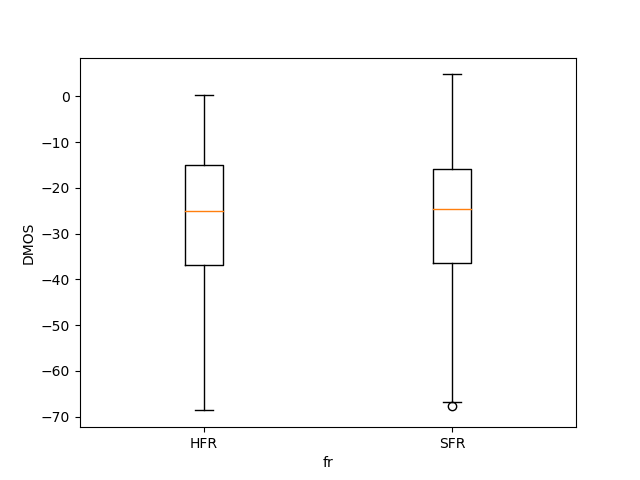

In [29]:
%matplotlib notebook

import matplotlib.pyplot as plt

scores_df = copy_df


codec = sorted(scores_df['codec'].unique())
content = sorted(scores_df['content'].unique())
fr = scores_df['fr'].unique()
res = sorted(scores_df['res'].unique())
bitrate = sorted(scores_df['bitrate'].unique(),key=int)


# def plot_by_col(col_vals,col_name):
#     scores = []
#     df2 = pd.DataFrame(scores)

#     for val in col_vals:
#         scores.append(scores_df[scores_df[col_name]==val].dmos.values)
#     plt.boxplot(scores,labels=col_vals)
#     plt.xlabel(col_name)
#     plt.ylabel('DMOS')
#     plt.show()
def plot_by_sorted_col(col_vals,col_name):
    scores = []

    

    for val in col_vals:
        scores.append(scores_df[scores_df[col_name]==val].dmos.values)
    meds = [np.median(s) for s in scores]
    sorted_indices = np.argsort(meds)
    sorted_scores = [scores[i] for i in sorted_indices]
    plt.figure()
    plt.boxplot(sorted_scores,labels=col_vals)
    plt.xlabel(col_name)
    plt.ylabel('DMOS')
    plt.show()

plot_by_sorted_col(content,'content')
plot_by_sorted_col(res,'res')
plot_by_sorted_col(codec,'codec')
plot_by_sorted_col(bitrate,'bitrate')
plot_by_sorted_col(fr,'fr')





## Plot HFR vs SFR DMOS by different content

<IPython.core.display.Javascript object>


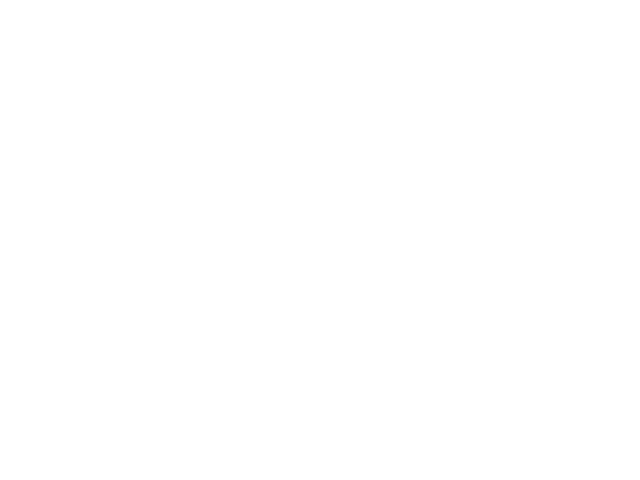

<IPython.core.display.Javascript object>


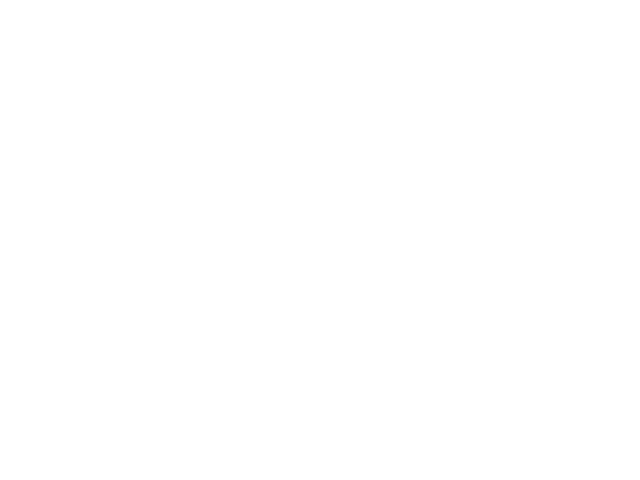

<IPython.core.display.Javascript object>


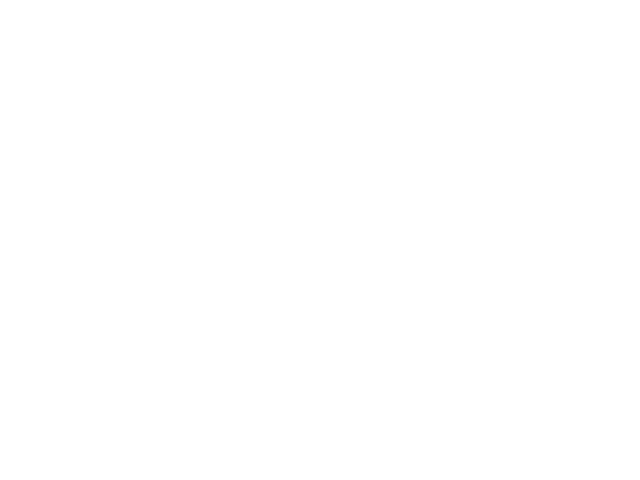

<IPython.core.display.Javascript object>


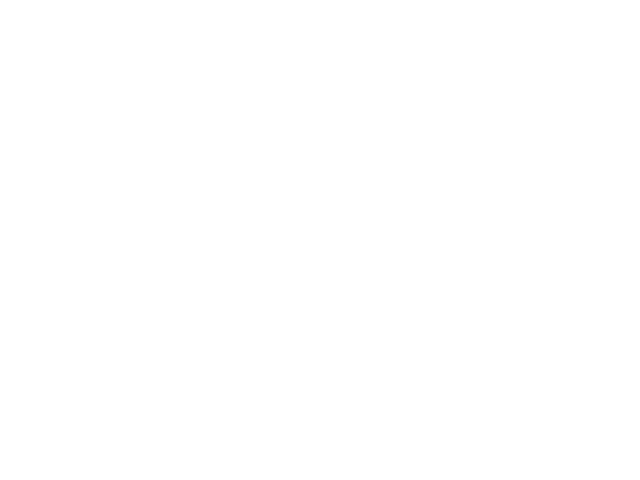

<IPython.core.display.Javascript object>


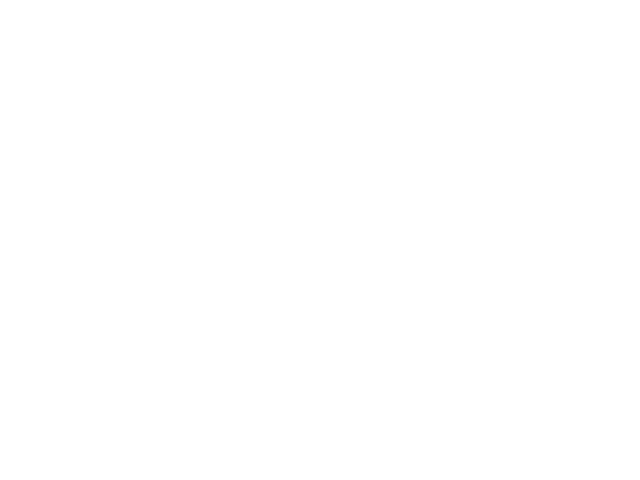

<IPython.core.display.Javascript object>


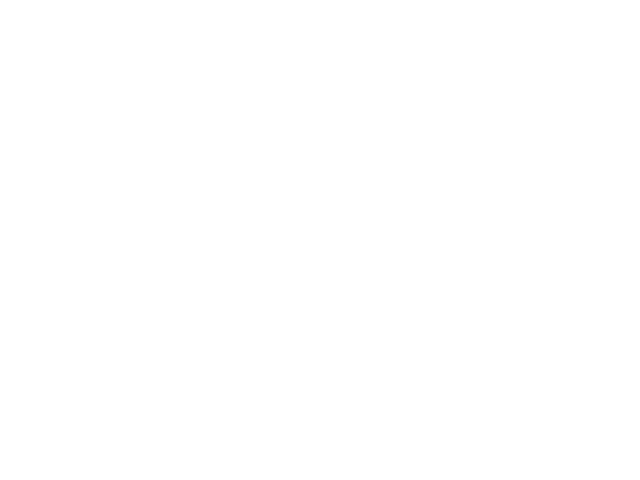

<IPython.core.display.Javascript object>


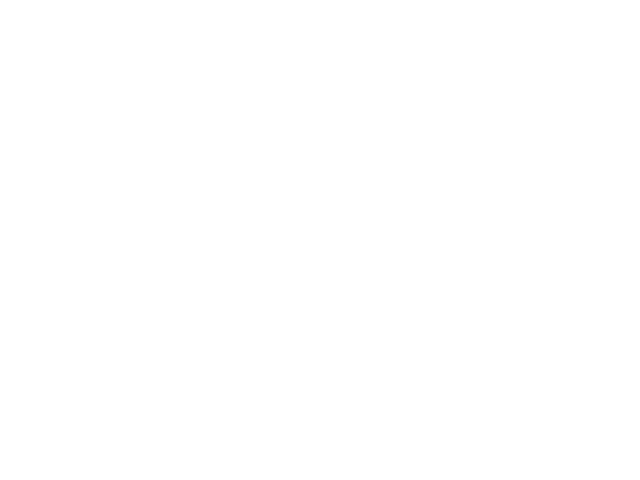

<IPython.core.display.Javascript object>


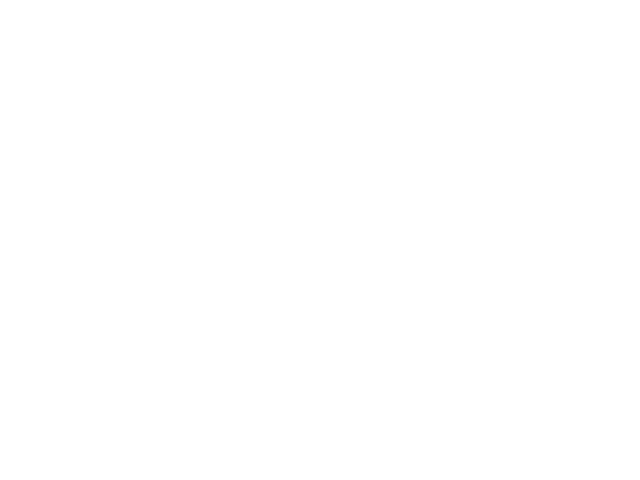

<IPython.core.display.Javascript object>


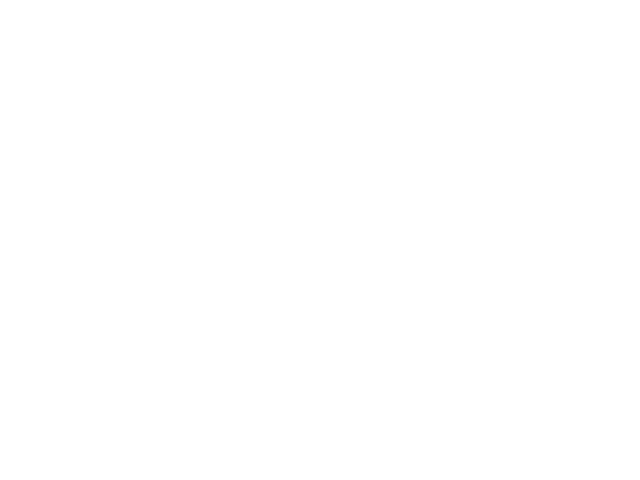

<IPython.core.display.Javascript object>


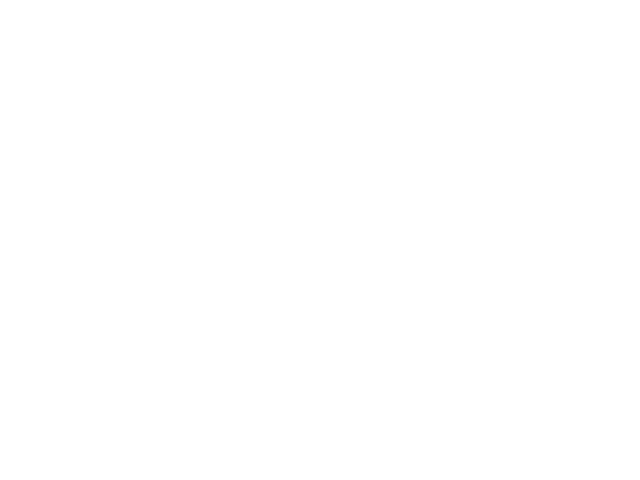

<IPython.core.display.Javascript object>


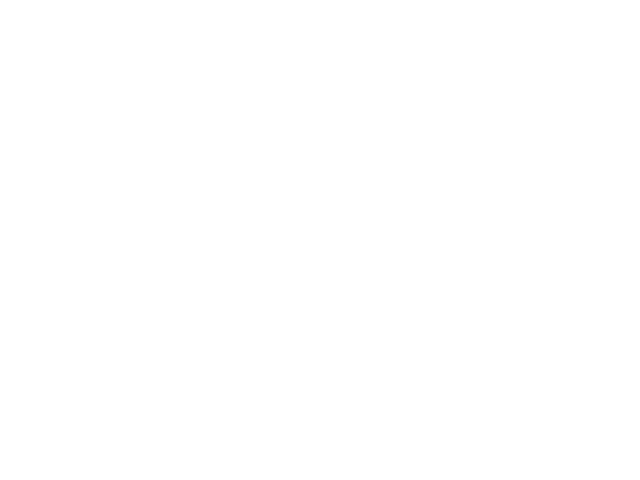

<IPython.core.display.Javascript object>


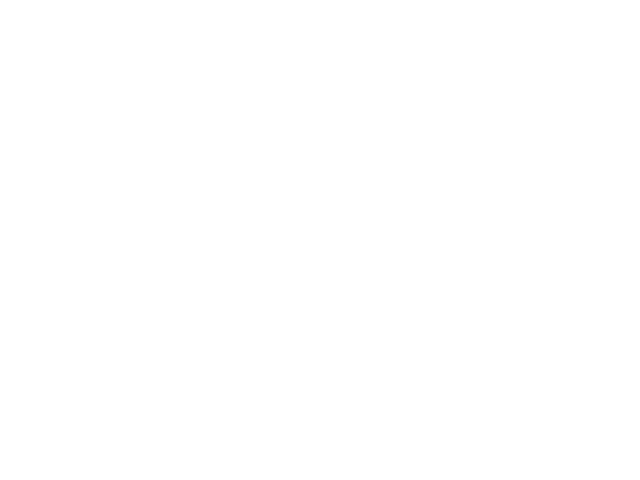

<IPython.core.display.Javascript object>


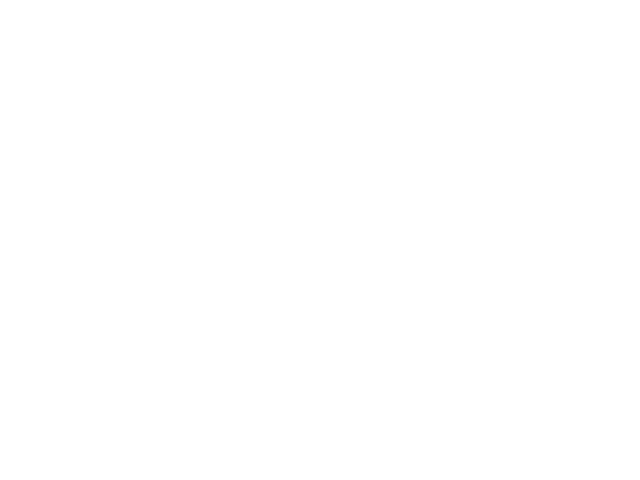

<IPython.core.display.Javascript object>


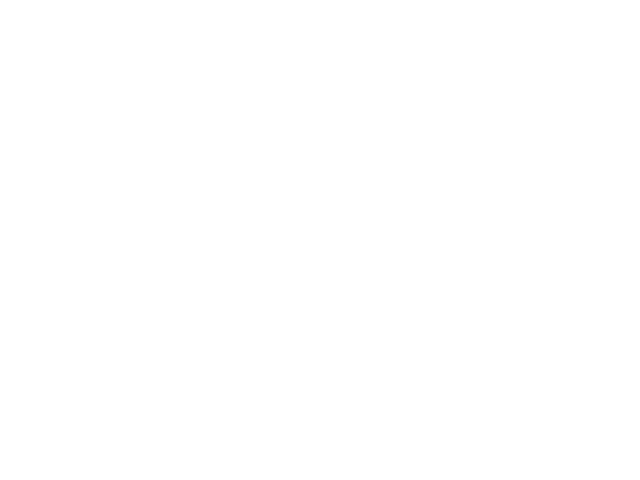

<IPython.core.display.Javascript object>


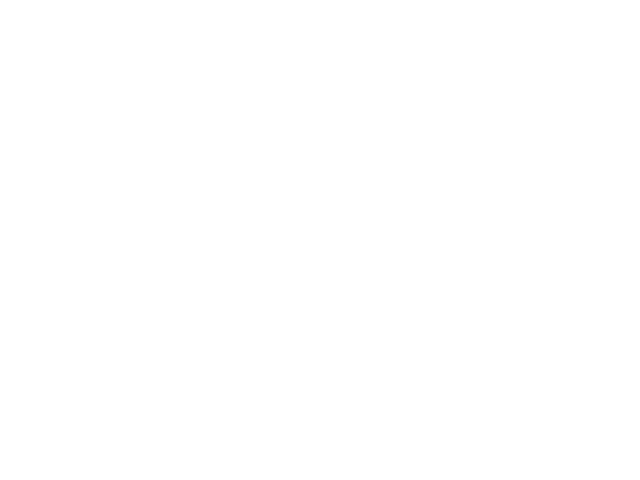

<IPython.core.display.Javascript object>


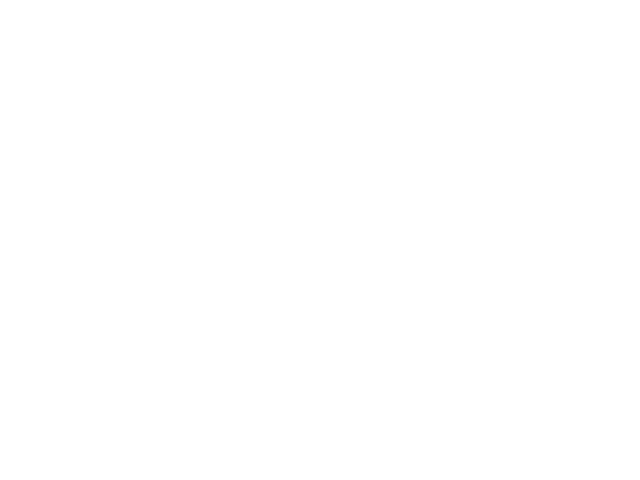

<IPython.core.display.Javascript object>


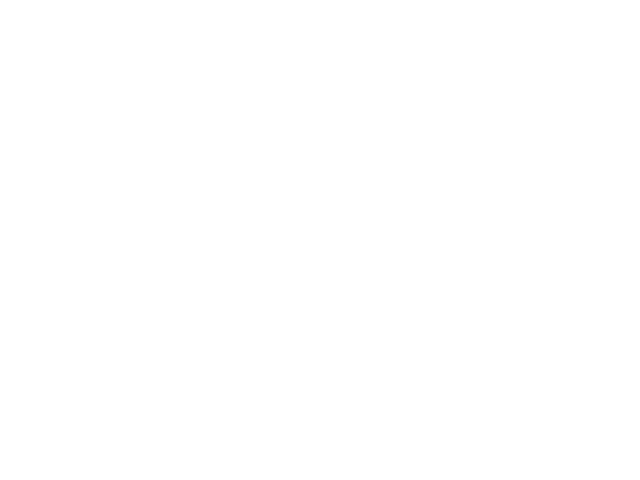

<IPython.core.display.Javascript object>


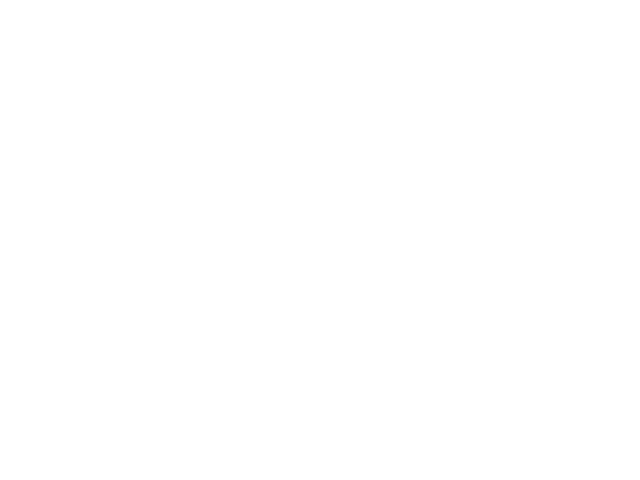

<IPython.core.display.Javascript object>


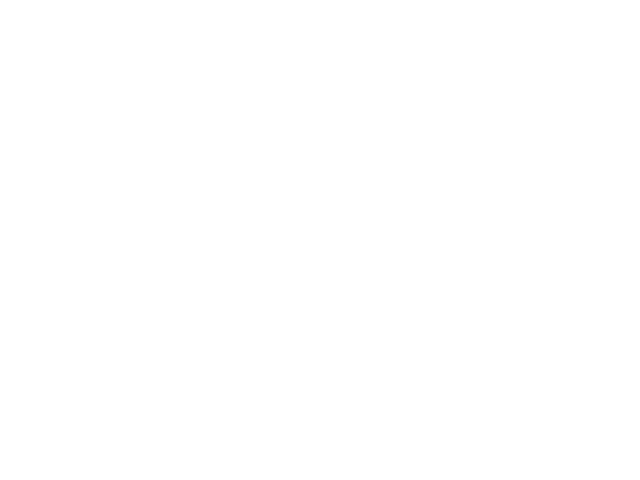

<IPython.core.display.Javascript object>


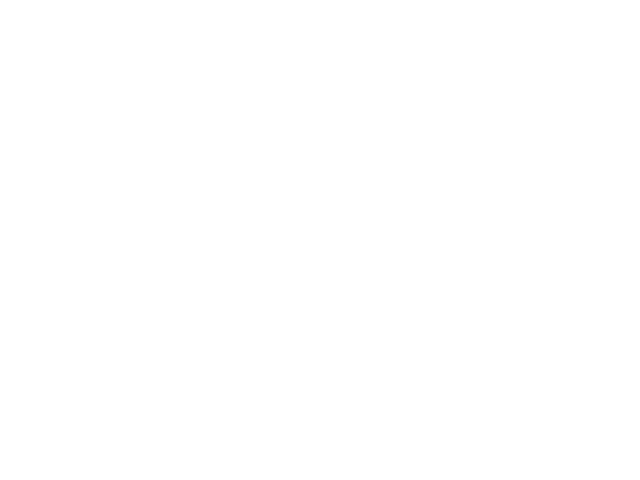

<ipython-input-9-7238c6c828ba>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


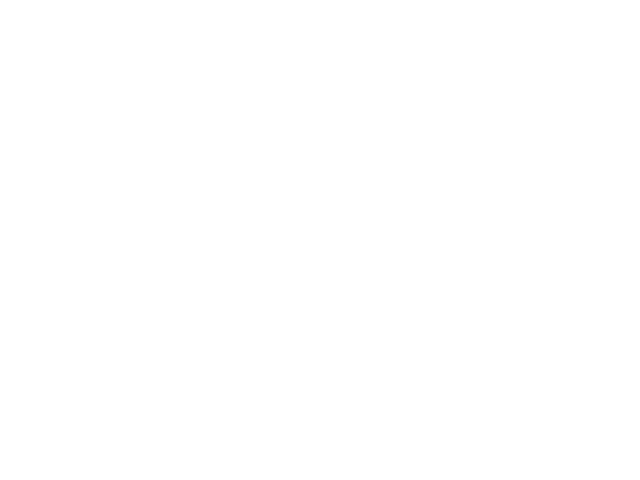

<IPython.core.display.Javascript object>


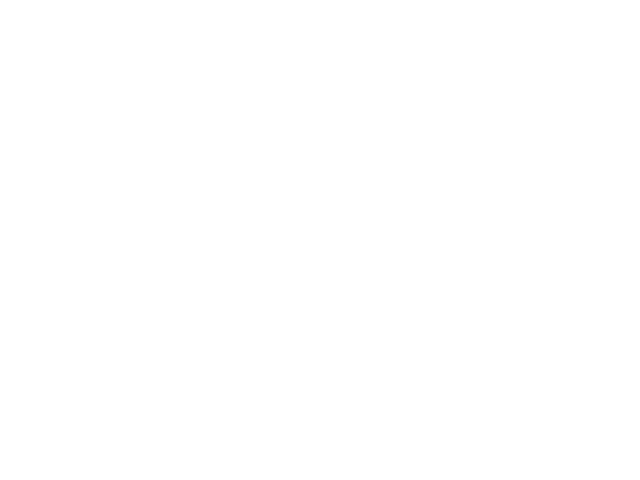

<IPython.core.display.Javascript object>


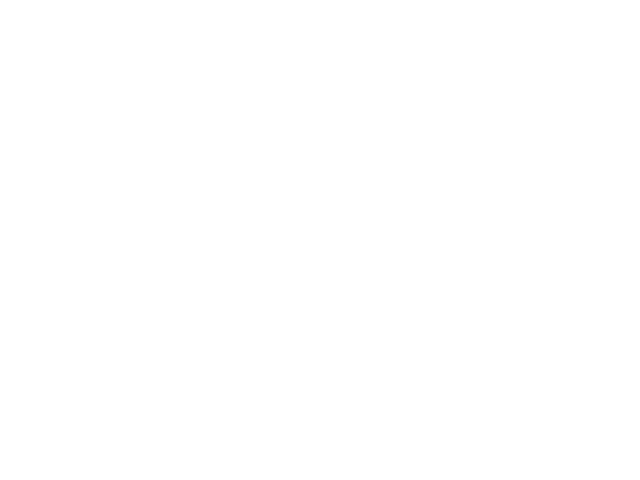

<IPython.core.display.Javascript object>


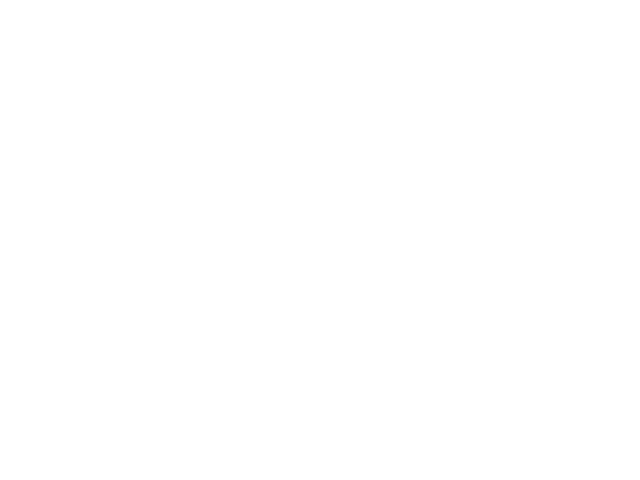

<IPython.core.display.Javascript object>


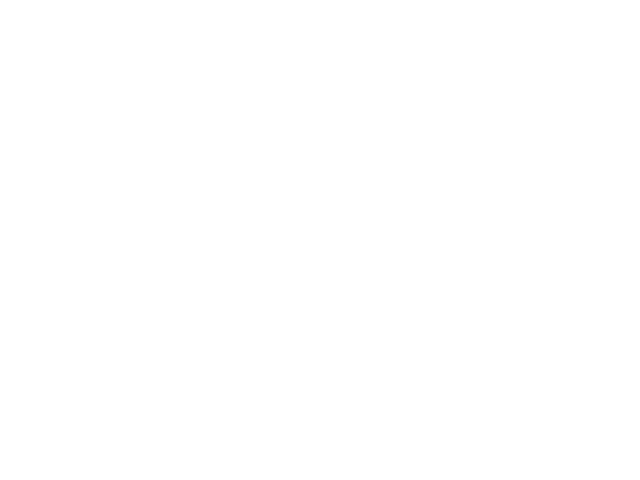

<IPython.core.display.Javascript object>


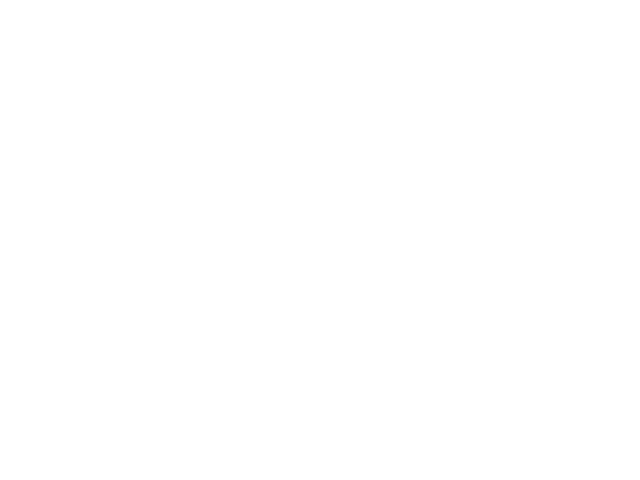

<IPython.core.display.Javascript object>


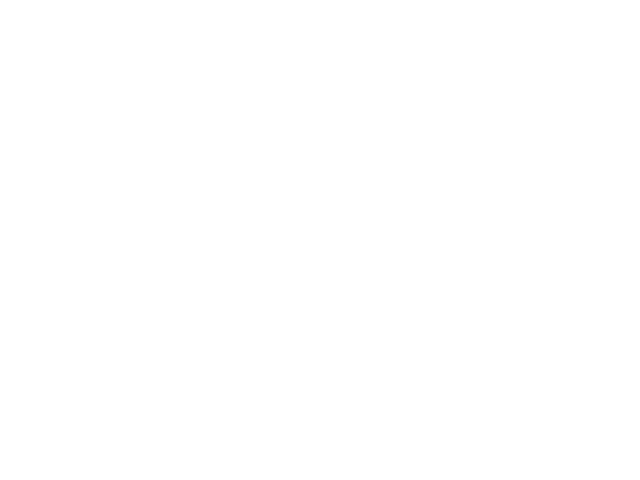

<IPython.core.display.Javascript object>


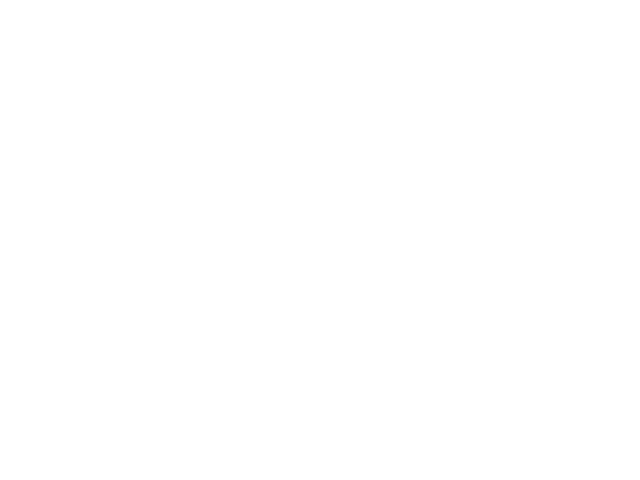

<IPython.core.display.Javascript object>


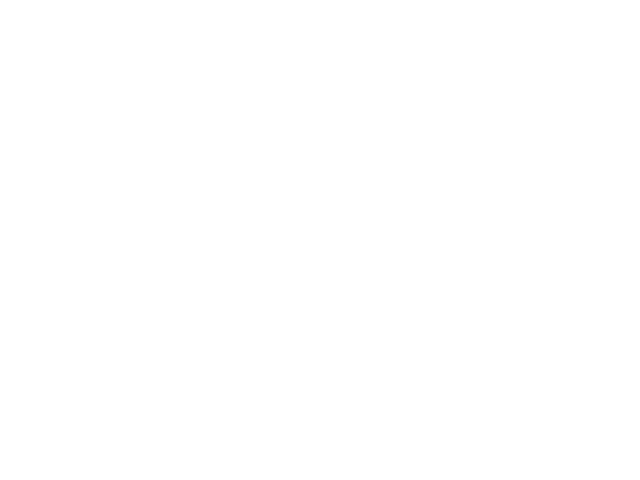

<IPython.core.display.Javascript object>


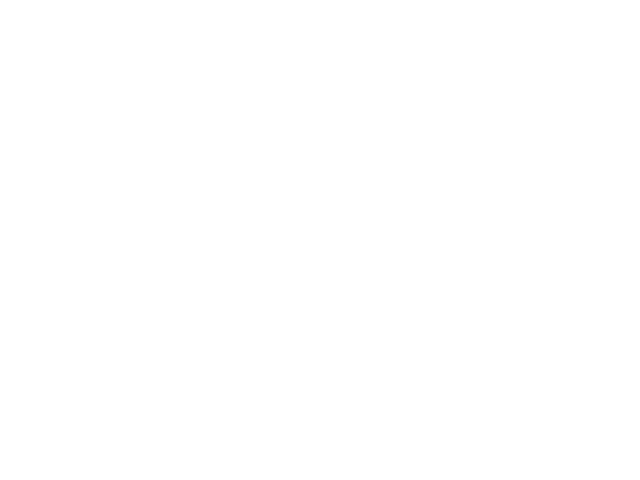

<IPython.core.display.Javascript object>


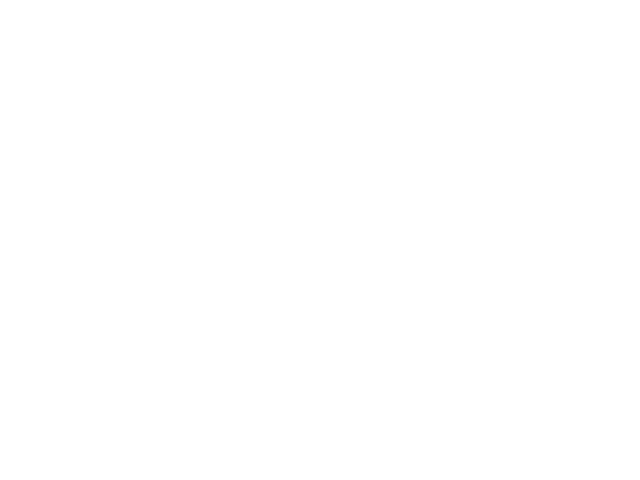

<IPython.core.display.Javascript object>


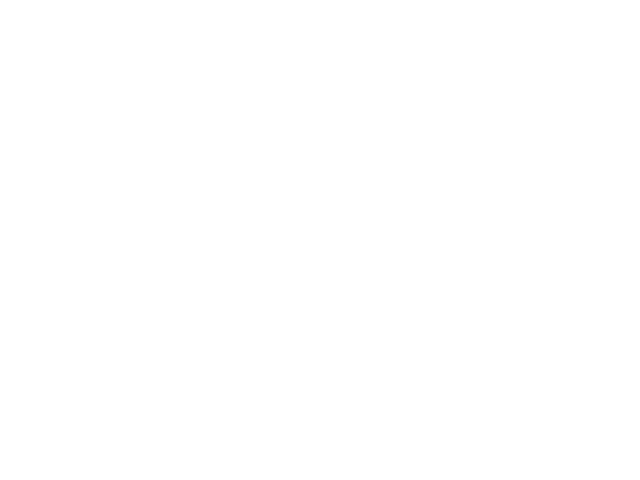

<IPython.core.display.Javascript object>


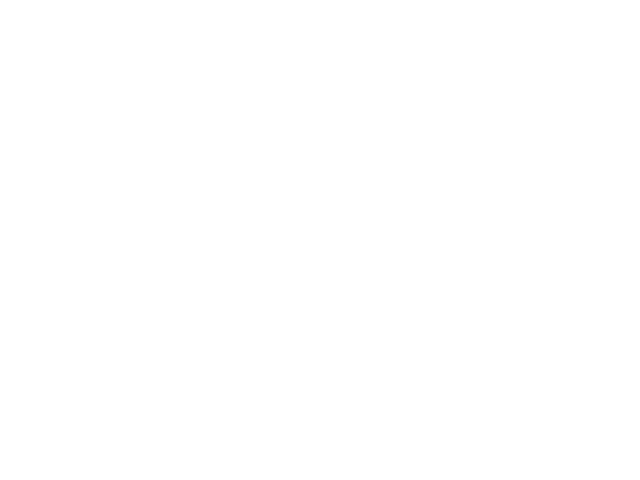

<IPython.core.display.Javascript object>


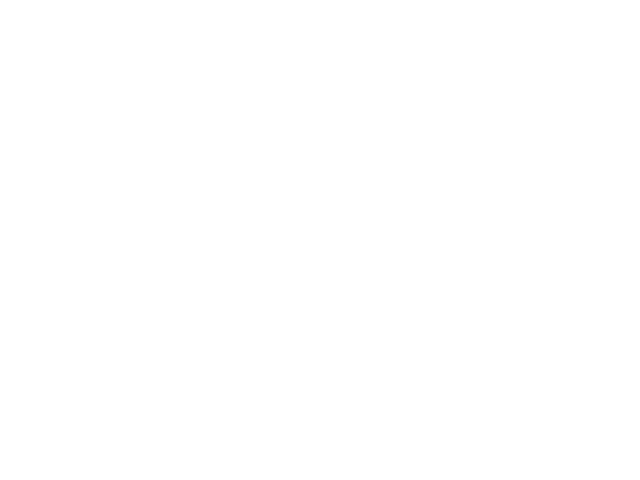

<IPython.core.display.Javascript object>


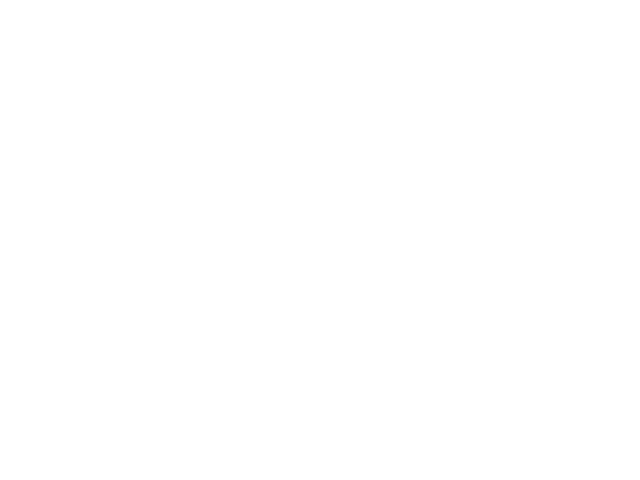

<IPython.core.display.Javascript object>


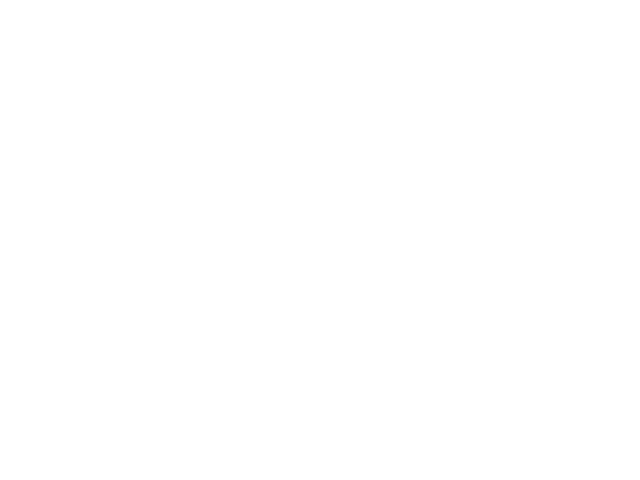

<IPython.core.display.Javascript object>


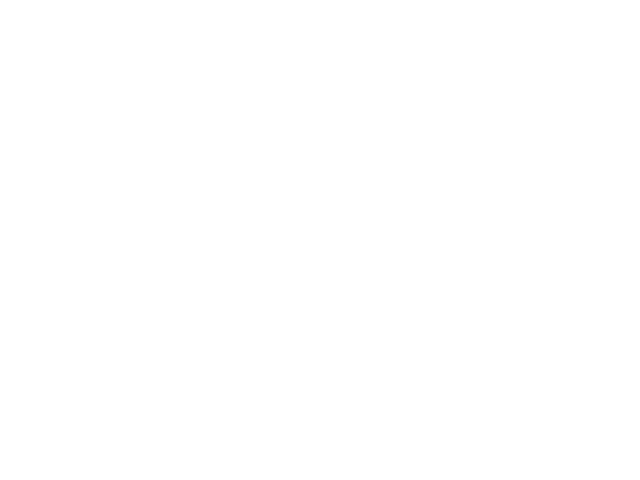

<IPython.core.display.Javascript object>


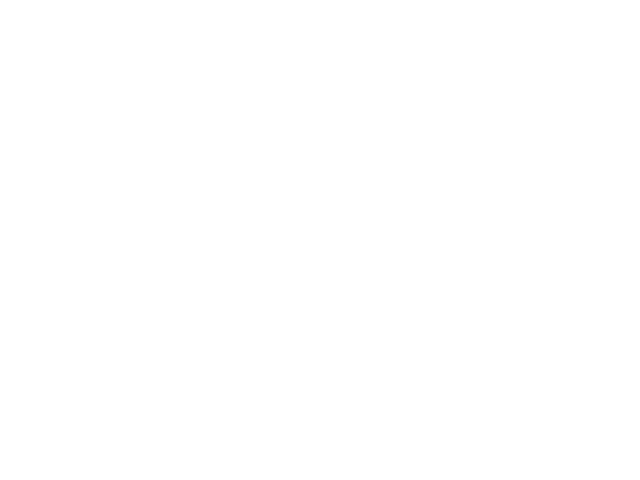

<IPython.core.display.Javascript object>


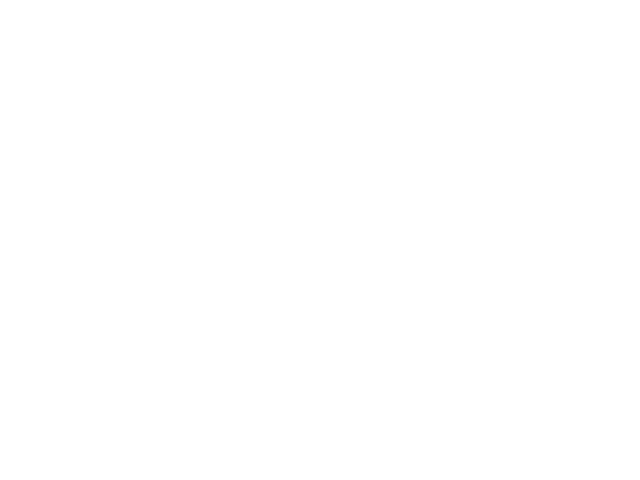

<IPython.core.display.Javascript object>


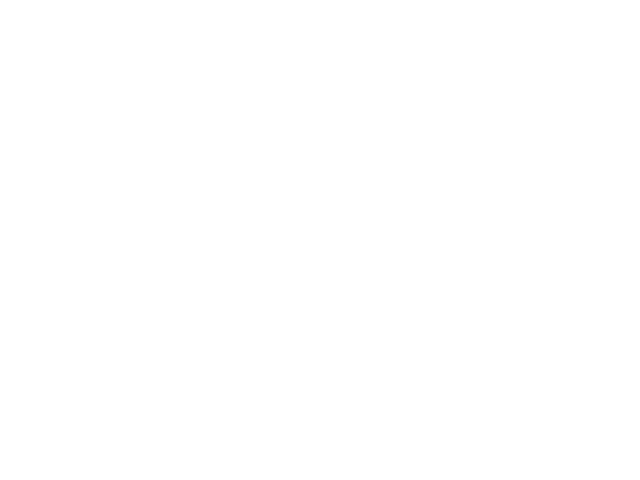

<IPython.core.display.Javascript object>


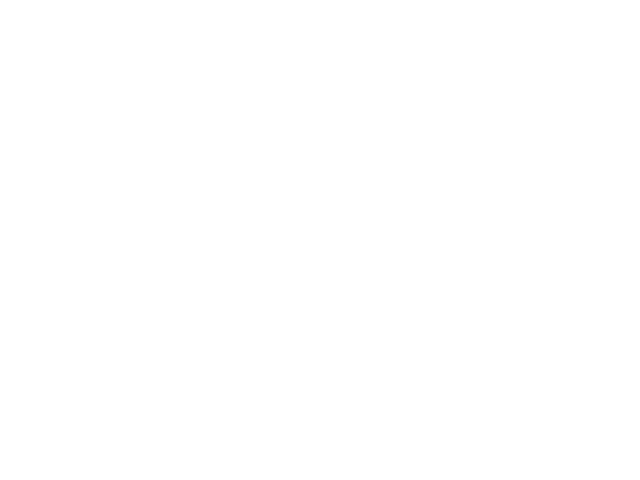

<IPython.core.display.Javascript object>


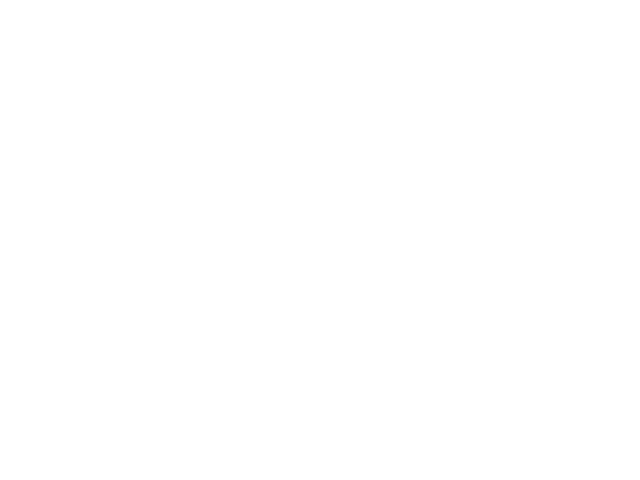

<IPython.core.display.Javascript object>


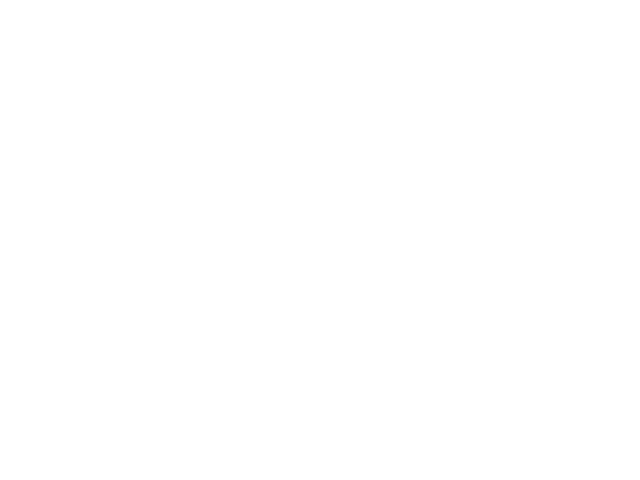

<IPython.core.display.Javascript object>


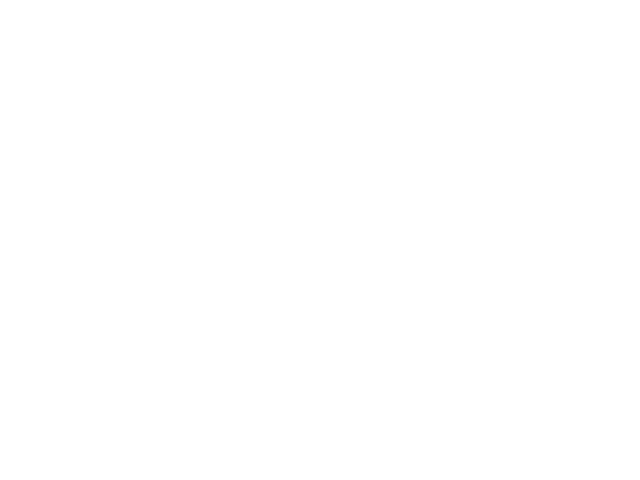

<IPython.core.display.Javascript object>


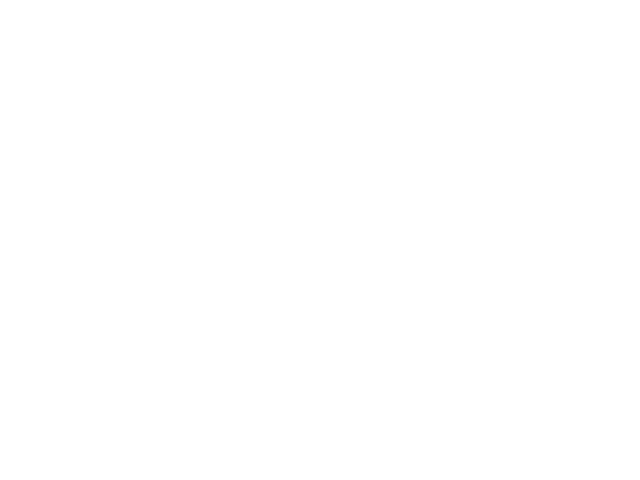

<IPython.core.display.Javascript object>


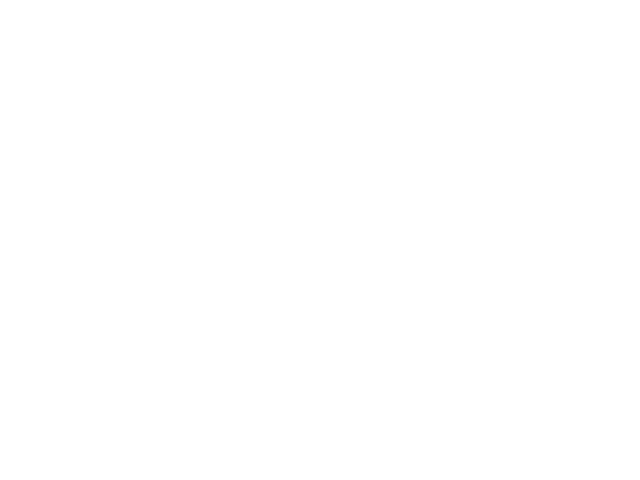

<IPython.core.display.Javascript object>


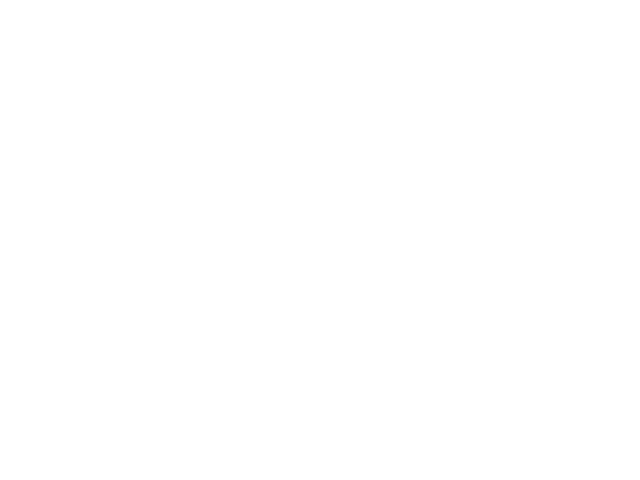

<IPython.core.display.Javascript object>


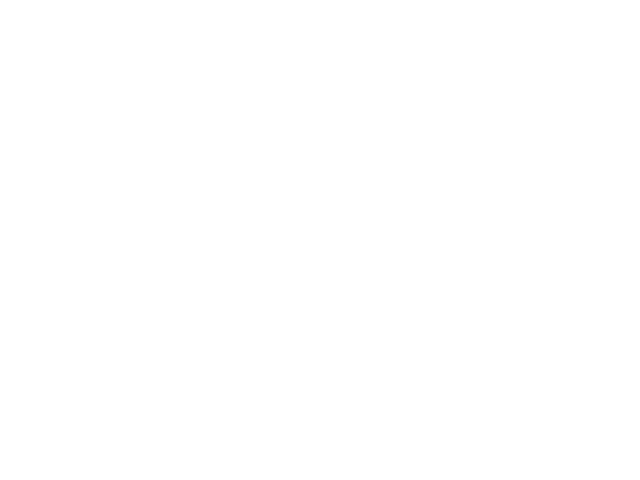

<IPython.core.display.Javascript object>


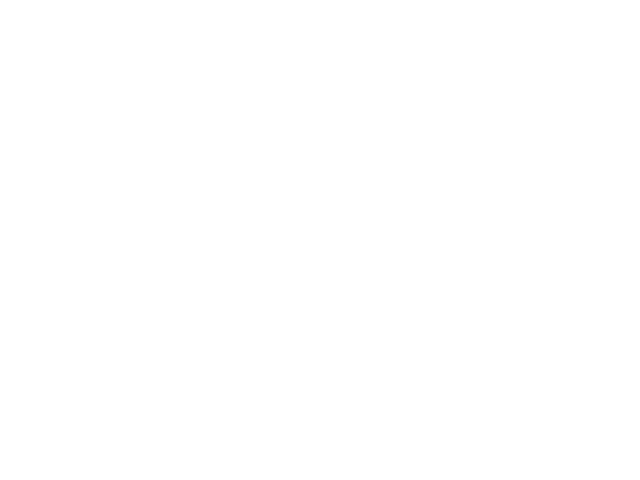

<IPython.core.display.Javascript object>


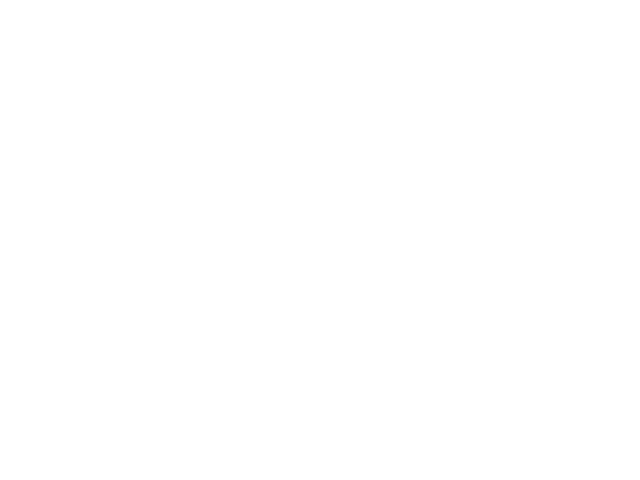

<IPython.core.display.Javascript object>


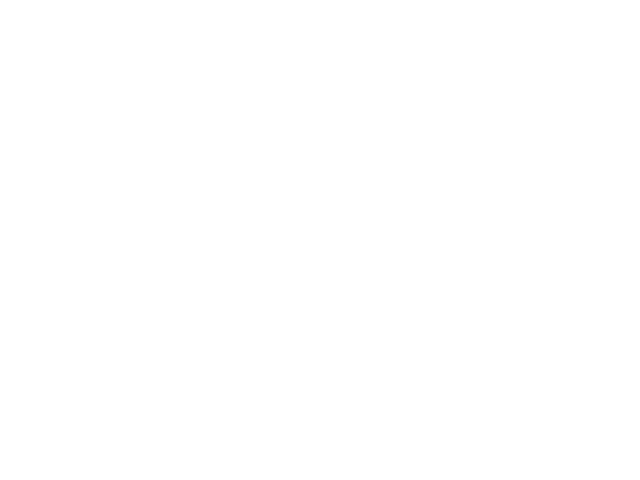

<IPython.core.display.Javascript object>


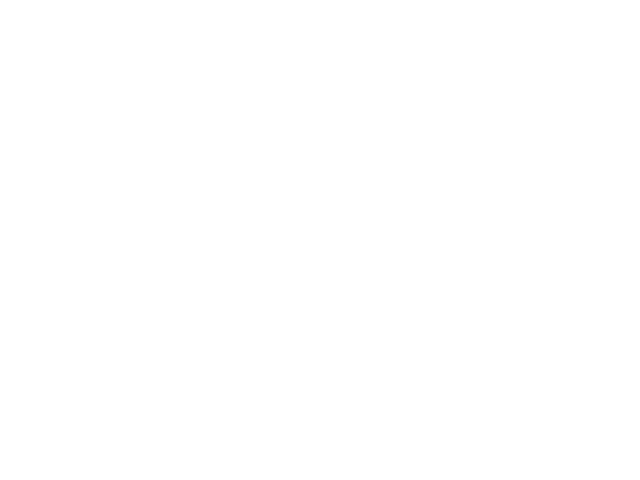

<IPython.core.display.Javascript object>


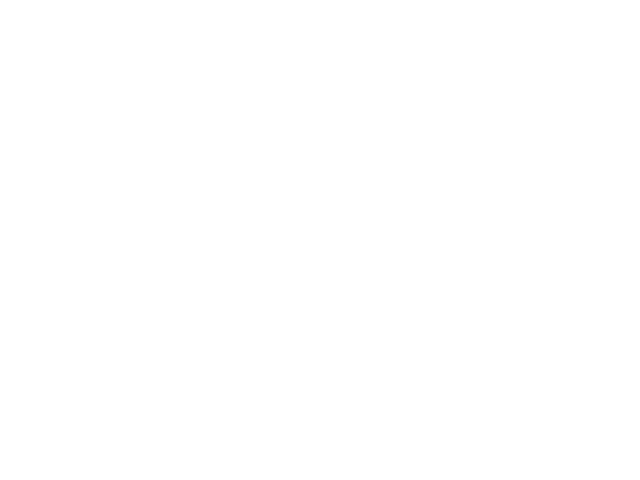

<IPython.core.display.Javascript object>


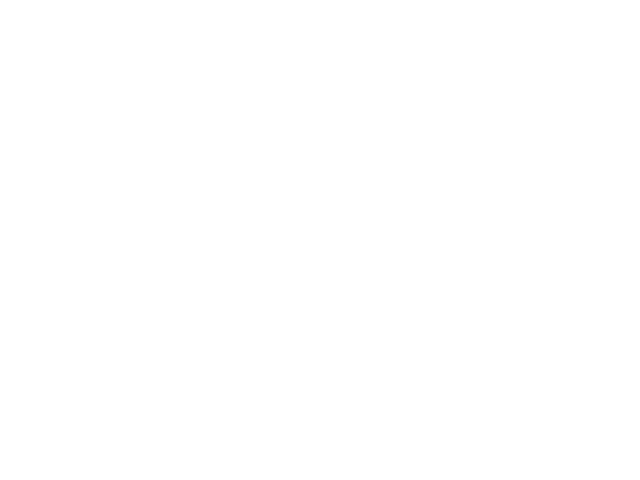

<IPython.core.display.Javascript object>


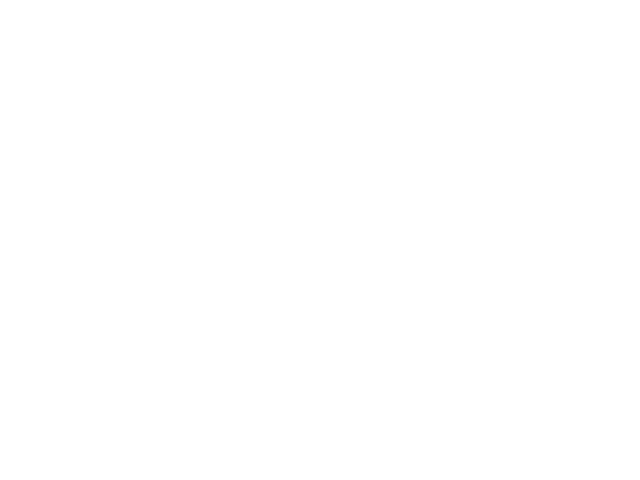

<IPython.core.display.Javascript object>


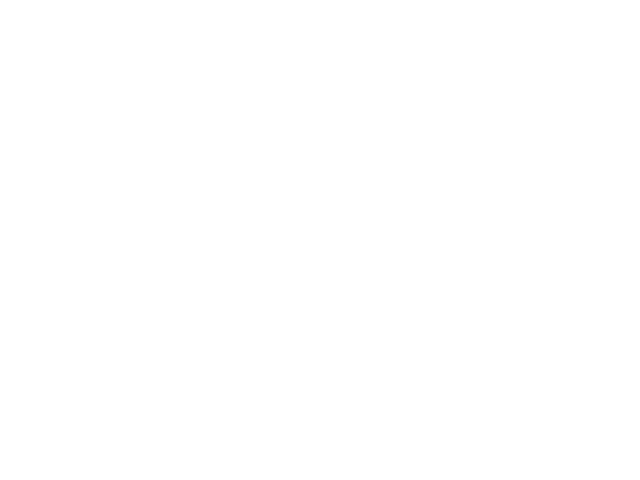

<IPython.core.display.Javascript object>


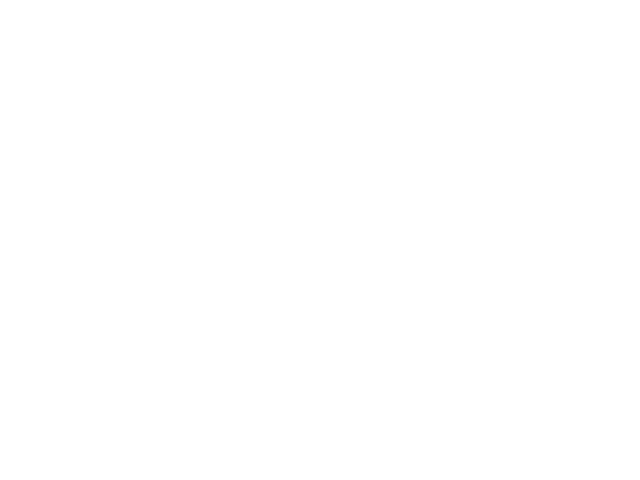

<IPython.core.display.Javascript object>


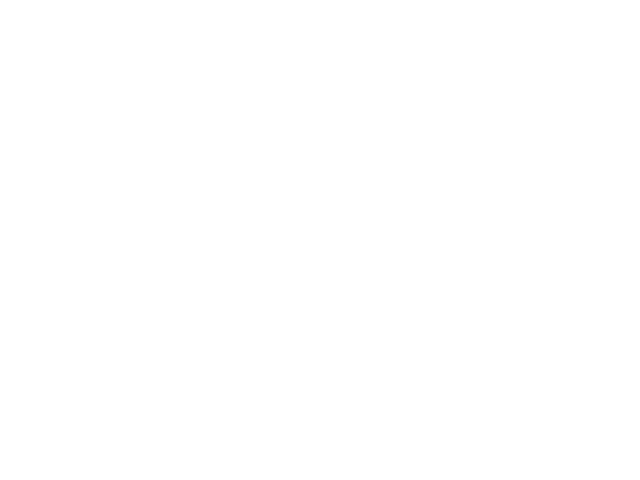

<IPython.core.display.Javascript object>


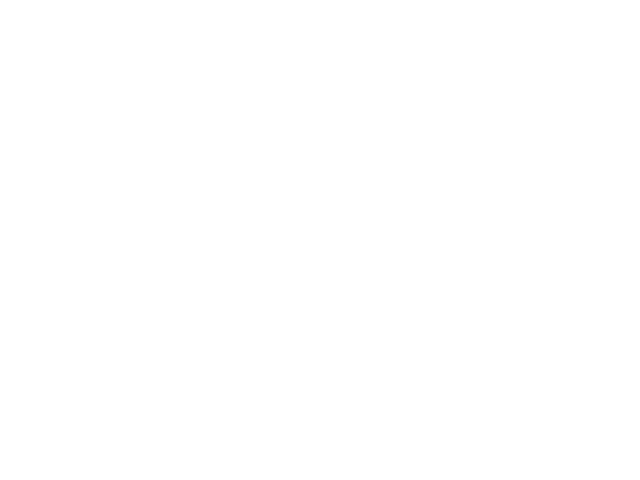

<IPython.core.display.Javascript object>


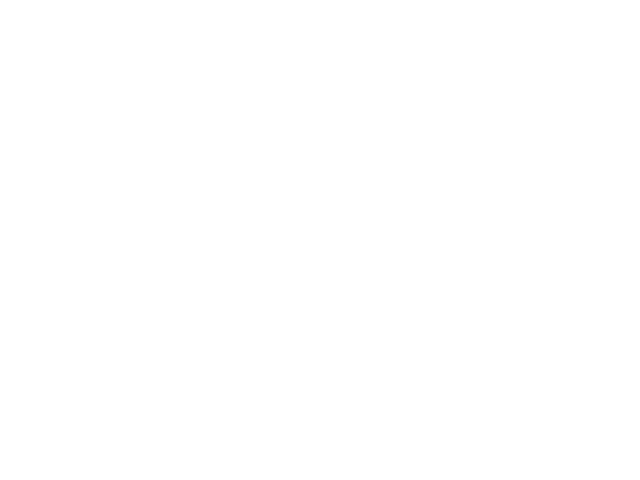

In [9]:
%matplotlib notebook

def sort_by_x(x,y):
    new_x, new_y = zip(*sorted(zip(x.astype(np.int32), y)))
    return new_x,new_y
def plot_by_fr(col_vals,col_name,codec):
    for val in col_vals:
        hfr_bitrates = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='HFR')& (scores_df['codec']==codec)].bitrate.values
        sfr_bitrates = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='SFR')& (scores_df['codec']==codec)].bitrate.values
        hfr_scores = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='HFR')& (scores_df['codec']==codec)].dmos.values
        sfr_scores = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='SFR')& (scores_df['codec']==codec)].dmos.values
        sfr_bitrates,sfr_scores = sort_by_x(sfr_bitrates,sfr_scores)
        hfr_bitrates,hfr_scores = sort_by_x(hfr_bitrates,hfr_scores)
        plt.figure()
        plt.plot(hfr_bitrates,hfr_scores,'g+',color='green',linestyle='dashed')
        plt.plot(sfr_bitrates,sfr_scores,'r+',color='red',linestyle='dashed')
        plt.legend(["HFR","SFR"])
        plt.xlabel('Bitrate (kbps)')
        plt.ylabel('DMOS')
        plt.title(val)
#        plt.savefig('./plots/HFR_v_SFR_'+codec+'_DMOS/'+val+'.png')
        plt.show()
#        plt.close()
        
        

plot_by_fr(content,'content','HEVC')
plot_by_fr(content,'content','AVC')

## Plot MOS of different reference videos

<IPython.core.display.Javascript object>


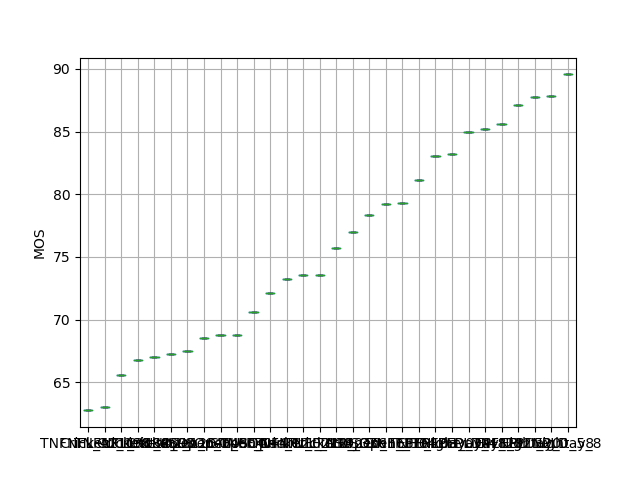

In [10]:
%matplotlib notebook

scores_df = pd.read_csv('./lbvfr_sepsess_zscore_mos.csv')


def plot_reference(col_vals,col_name):
    scores = []

    for val in col_vals:
        scores.append(scores_df[(scores_df[col_name]==val) & (scores_df['codec']=='SRC')].mos.values)
    scores = np.asarray(scores)
    df2 = pd.DataFrame(scores.T,columns=col_vals)

    meds = df2.median()
    meds.sort_values(ascending=True, inplace=True)
    df2 = df2[meds.index]
    plt.figure()
    df2.boxplot()
    plt.ylabel('MOS')
    plt.show()
plot_reference(content,'content')

## Internal Consistency of scores

0.9543258779126716


<IPython.core.display.Javascript object>


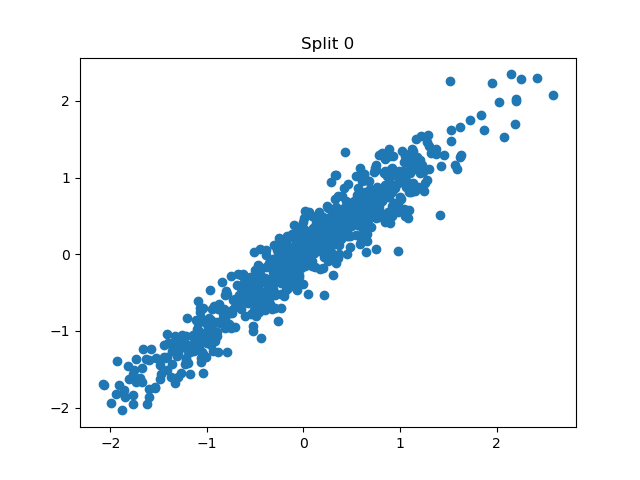

0.9591899434487882


<IPython.core.display.Javascript object>


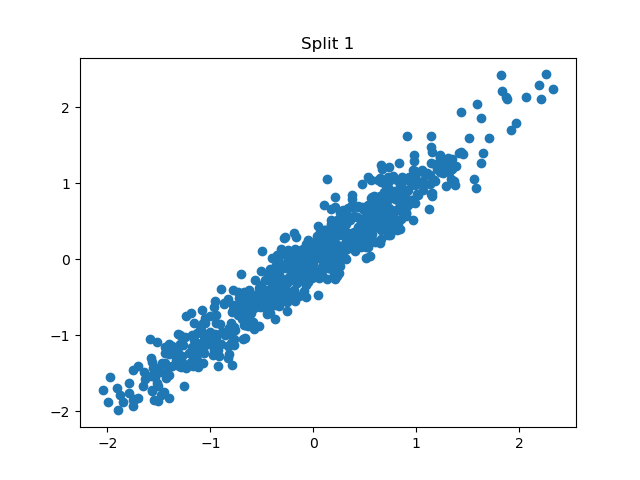

0.9547434999884442


<IPython.core.display.Javascript object>


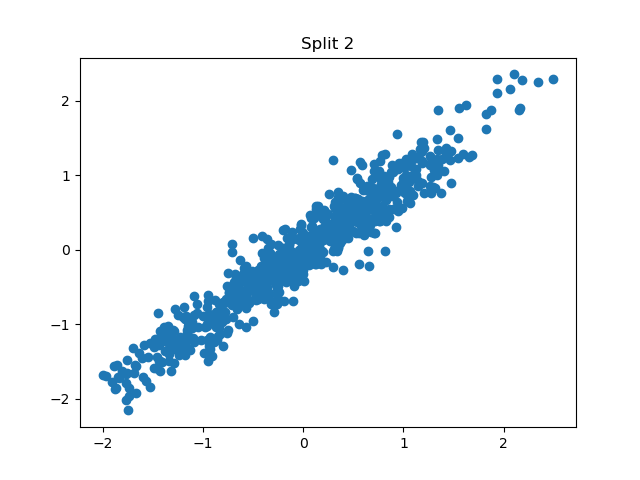

0.9553343205943475


<IPython.core.display.Javascript object>


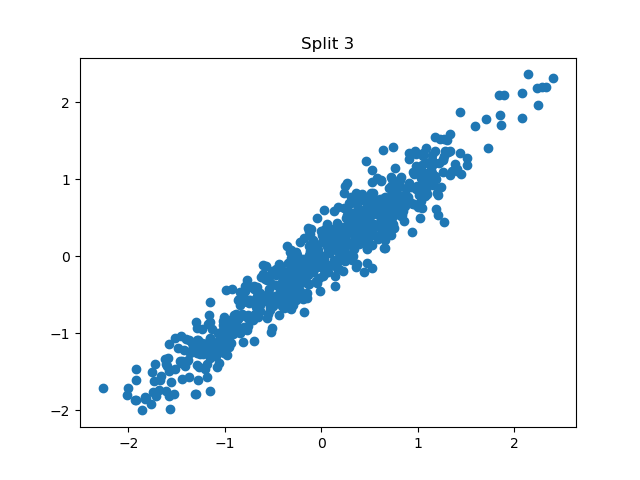

0.9564693412788288


<IPython.core.display.Javascript object>


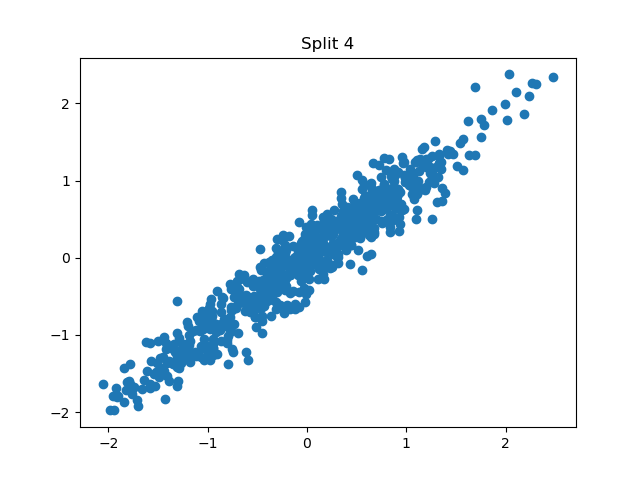

0.9574817093008163


<IPython.core.display.Javascript object>


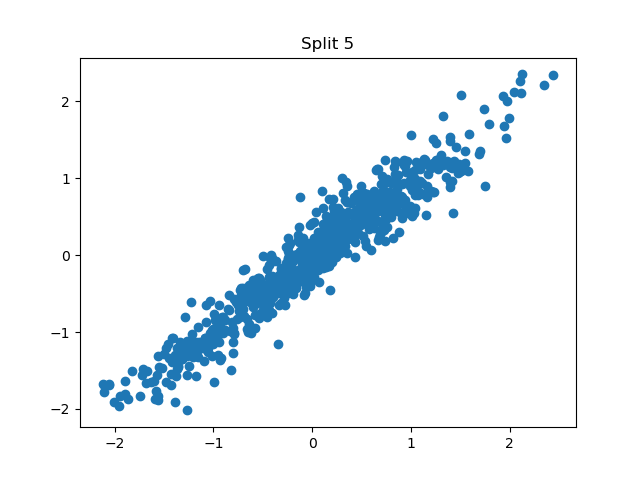

0.9528555535209838


<IPython.core.display.Javascript object>


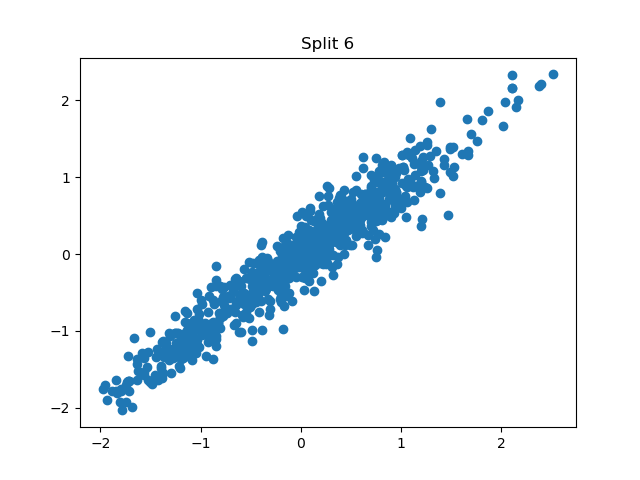

0.9584557341435272


<IPython.core.display.Javascript object>


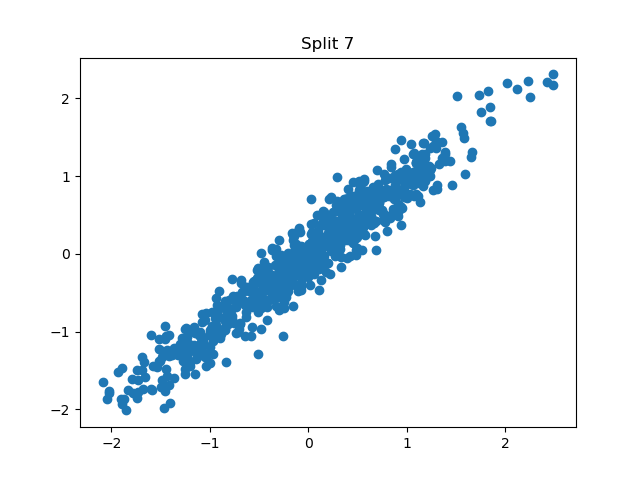

0.9573731366633538


<IPython.core.display.Javascript object>


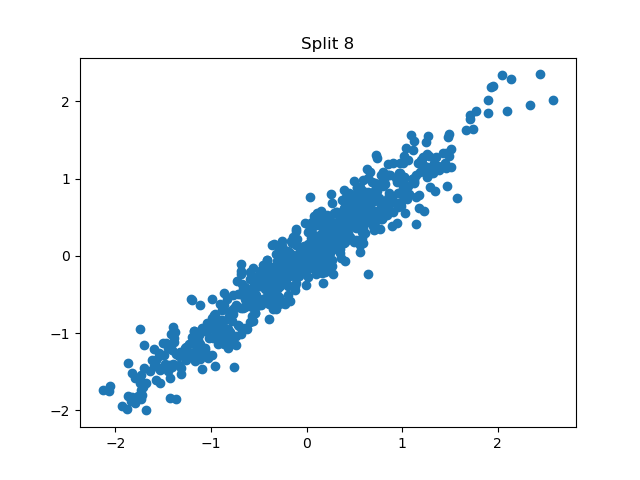

0.9607097328173027


<IPython.core.display.Javascript object>


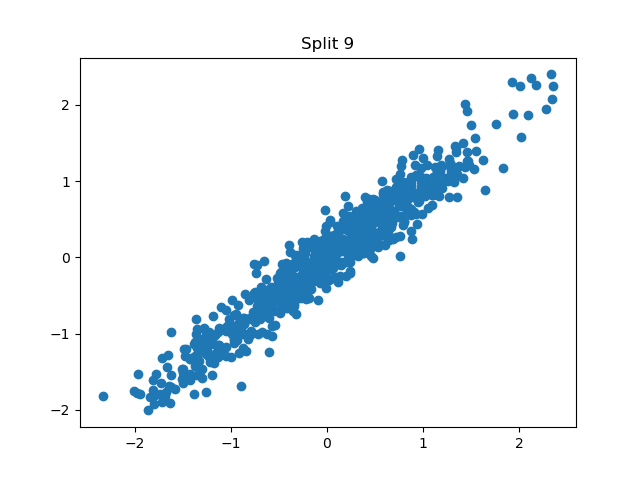

0.955776660936286


<IPython.core.display.Javascript object>


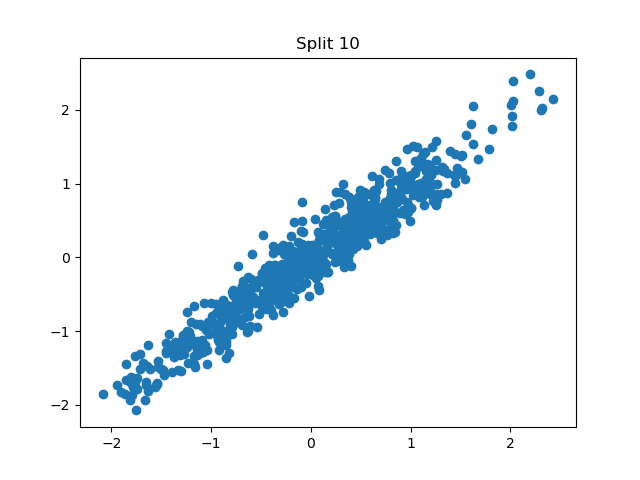

0.9560801352535736


<IPython.core.display.Javascript object>


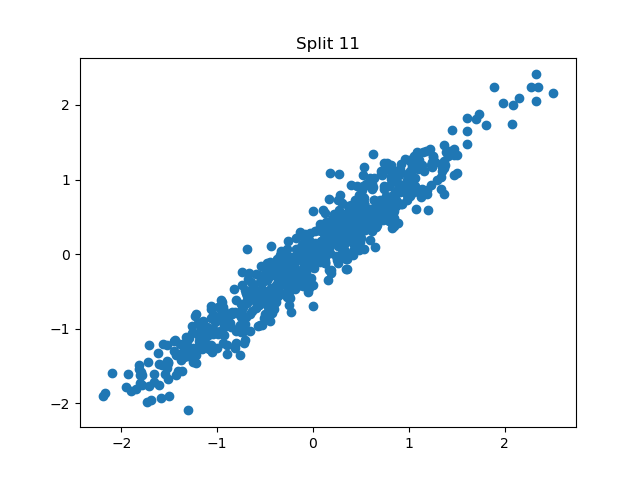

0.9549086487264865


<IPython.core.display.Javascript object>


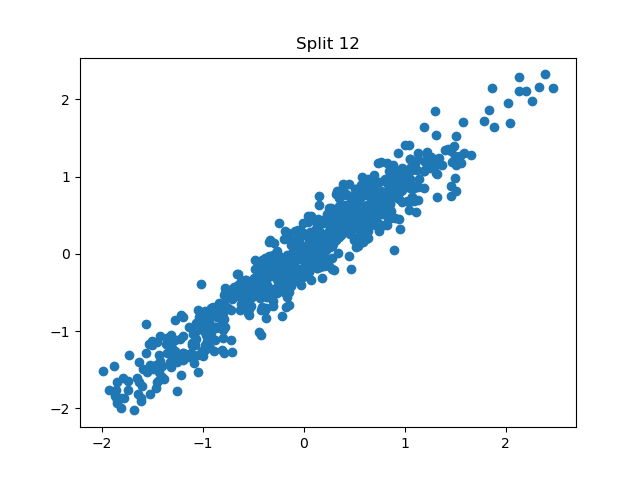

0.9545343476166179


<IPython.core.display.Javascript object>


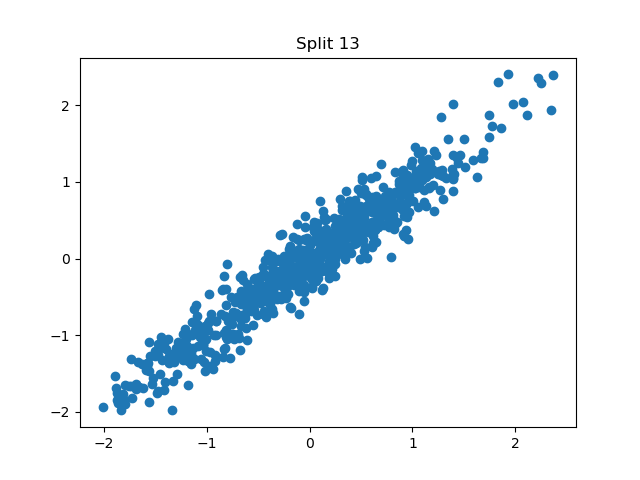

0.9602193781677832


<IPython.core.display.Javascript object>


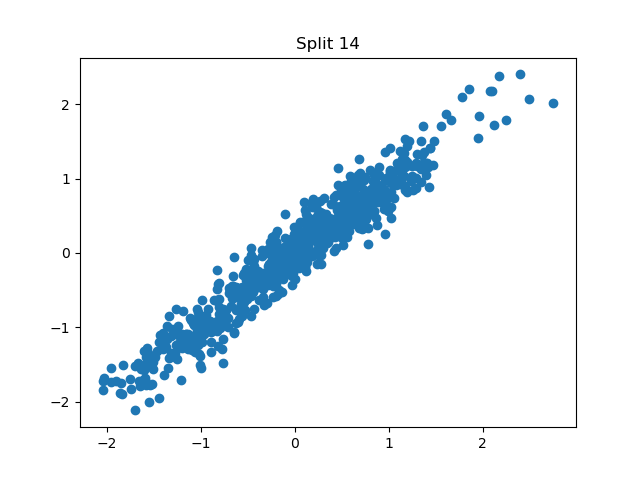

0.9551901354491296


<IPython.core.display.Javascript object>


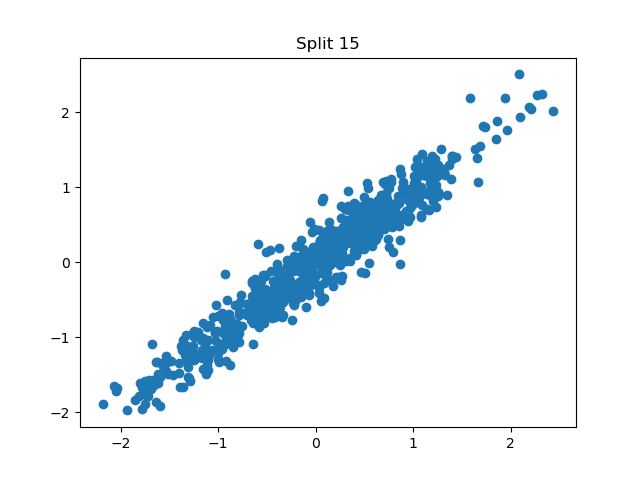

0.9525178604761964


<IPython.core.display.Javascript object>


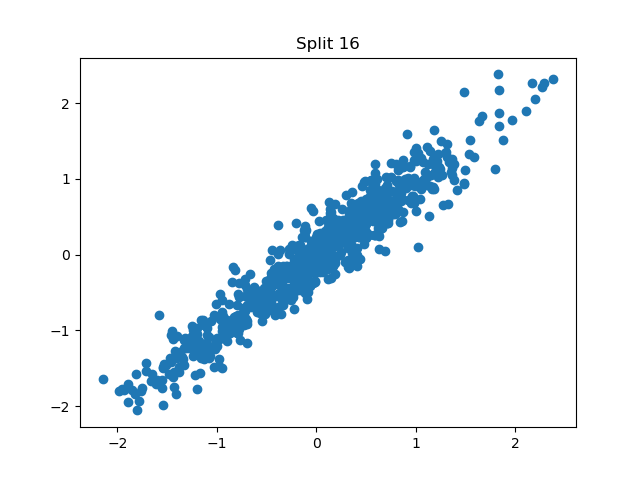

0.9559325083244592


<IPython.core.display.Javascript object>


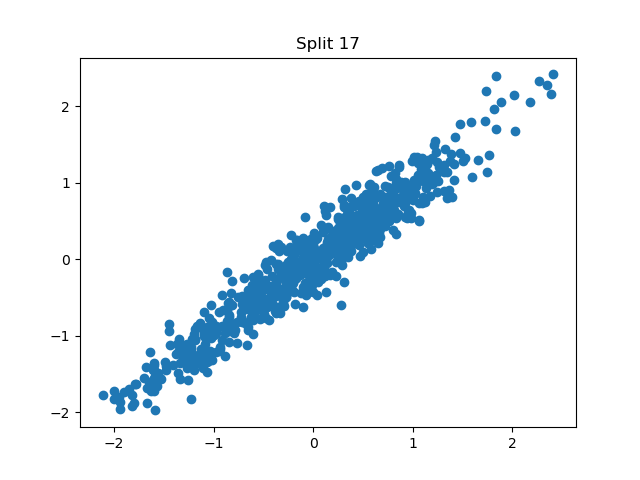

0.9563197516795583


<IPython.core.display.Javascript object>


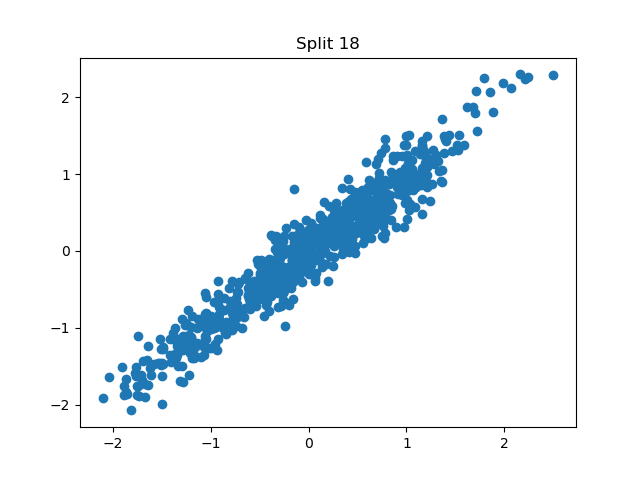

0.9535055671210081


<IPython.core.display.Javascript object>


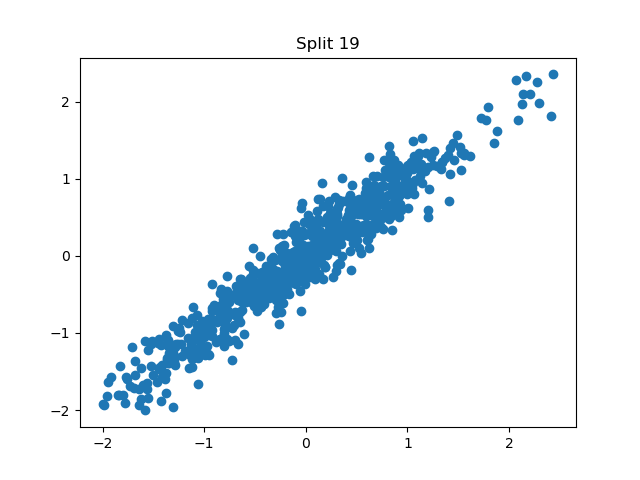

0.9499242629764675


<ipython-input-18-6f3759ff4d3a>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


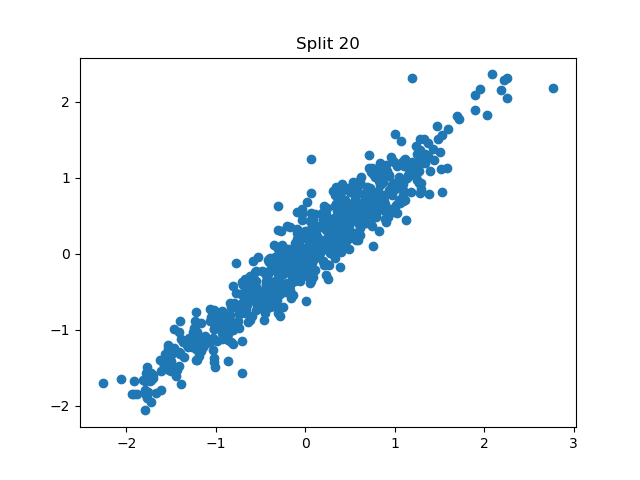

0.9538145596703281


<IPython.core.display.Javascript object>


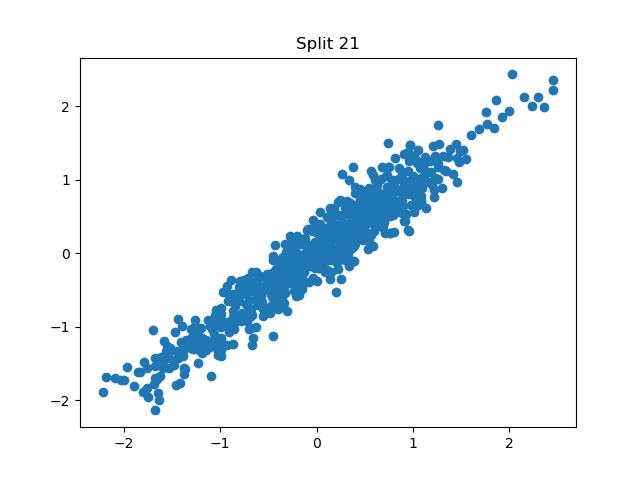

0.9502099025953823


<IPython.core.display.Javascript object>


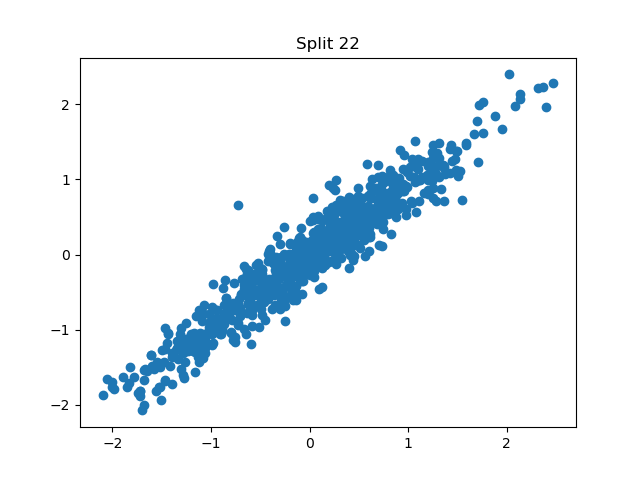

0.9584128967340385


<IPython.core.display.Javascript object>


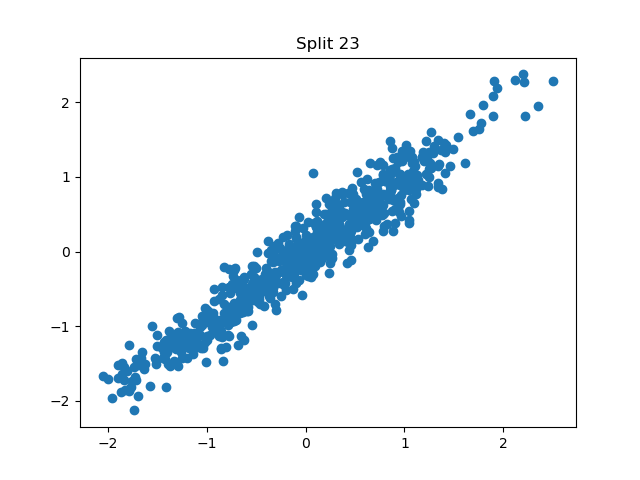

0.95374993377766


<IPython.core.display.Javascript object>


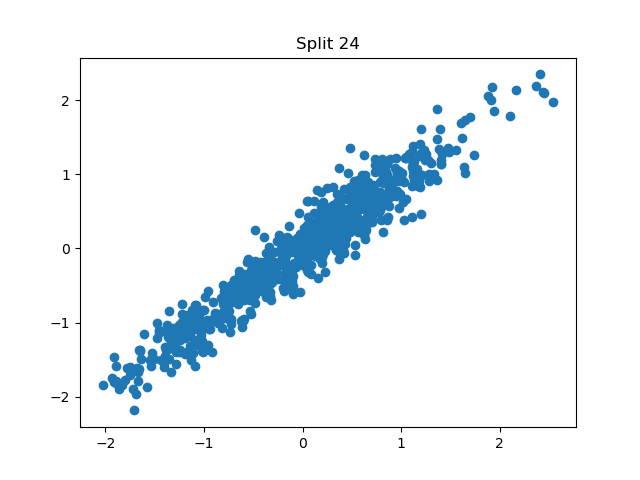

0.9590457583035702


<IPython.core.display.Javascript object>


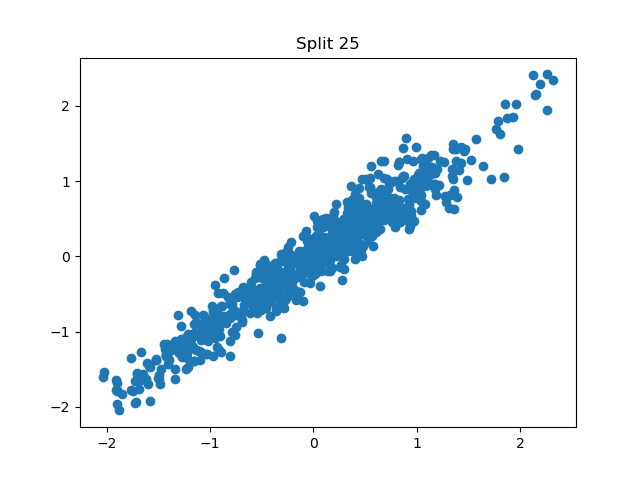

0.9577557435657661


<IPython.core.display.Javascript object>


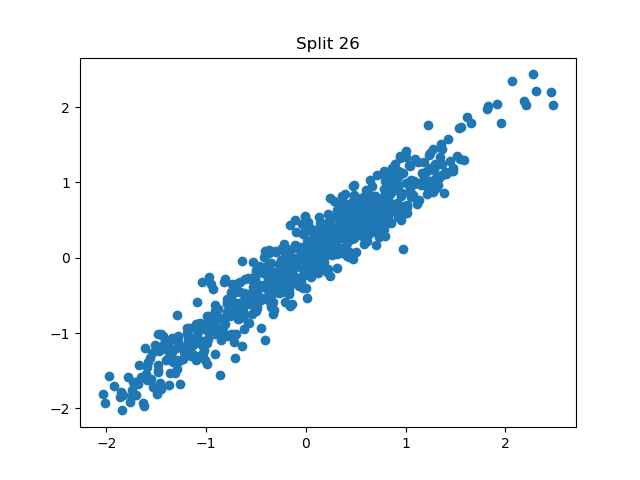

0.9571532038279178


<IPython.core.display.Javascript object>


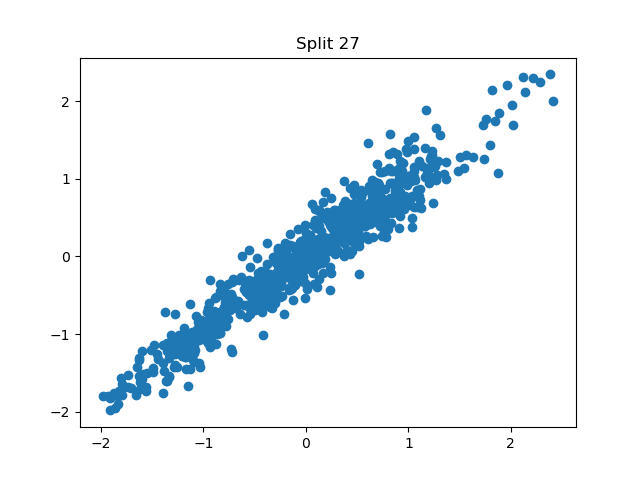

0.955980551076535


<IPython.core.display.Javascript object>


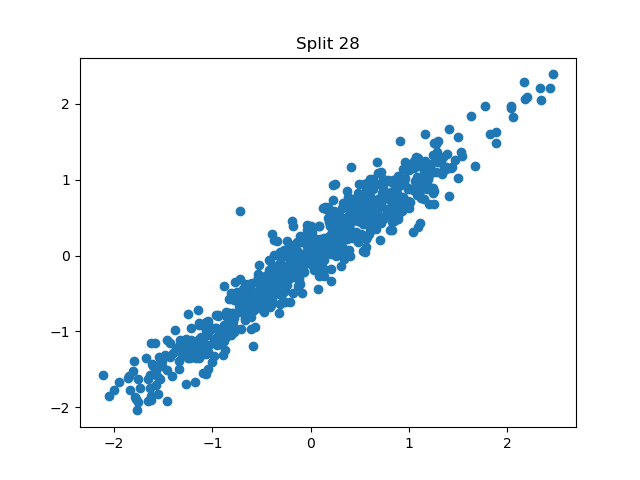

0.9573545908526059


<IPython.core.display.Javascript object>


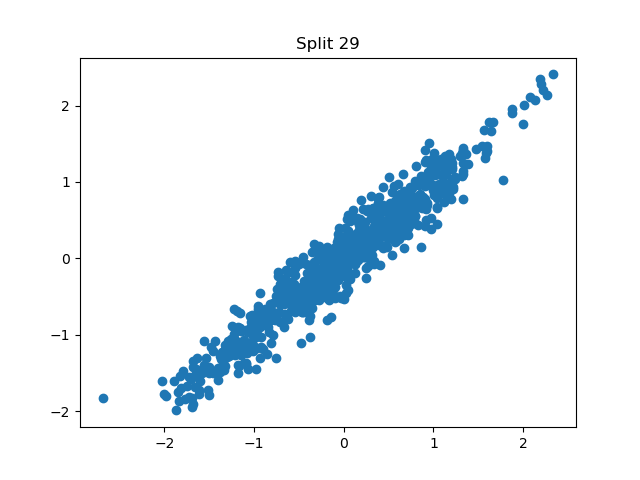

0.956275520489814


<IPython.core.display.Javascript object>


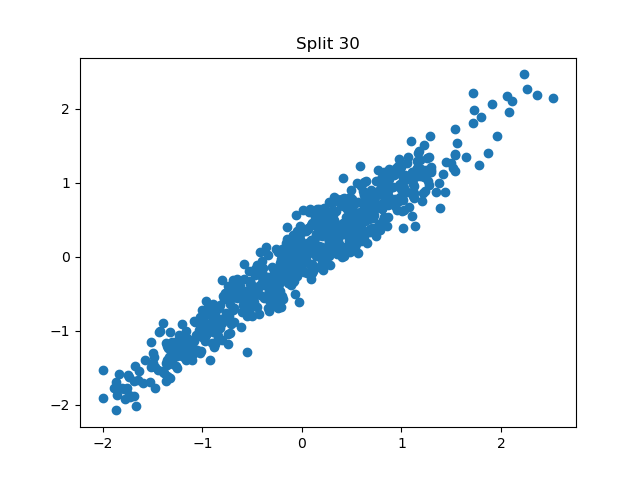

0.9577616884652237


<IPython.core.display.Javascript object>


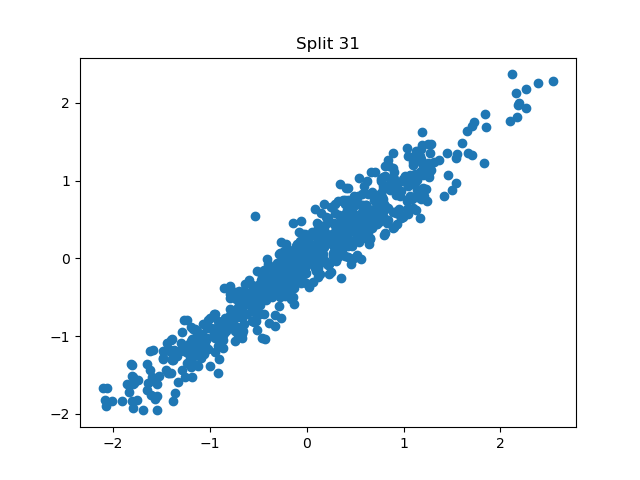

0.9552460857708189


<IPython.core.display.Javascript object>


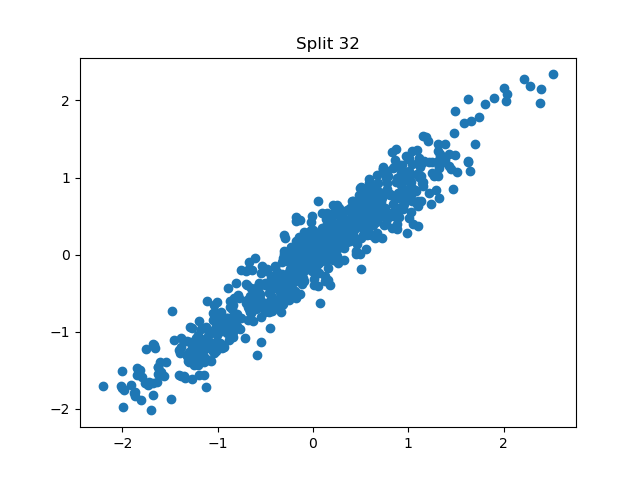

0.9541065139671359


<IPython.core.display.Javascript object>


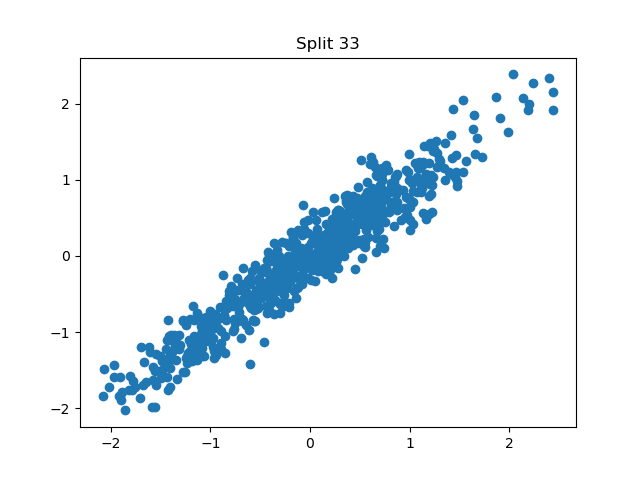

0.9528542166297184


<IPython.core.display.Javascript object>


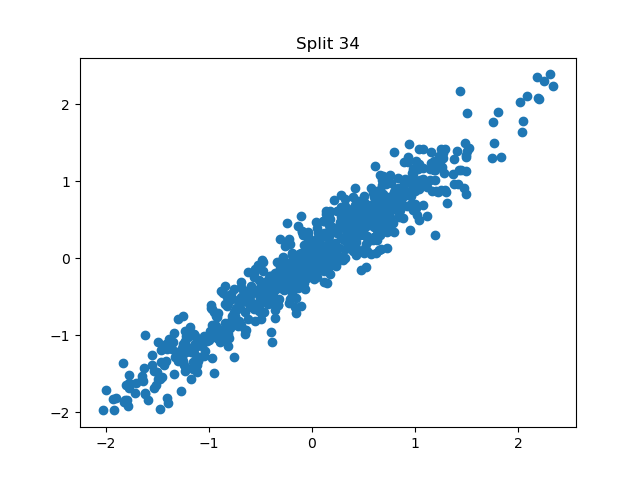

0.9572586760154239


<IPython.core.display.Javascript object>


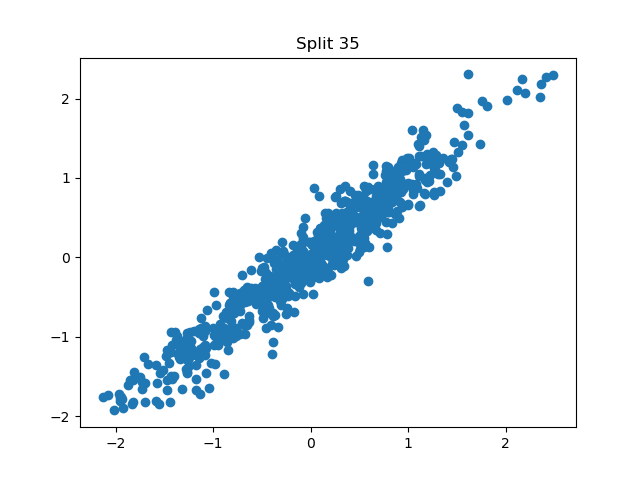

0.9531582598369063


<IPython.core.display.Javascript object>


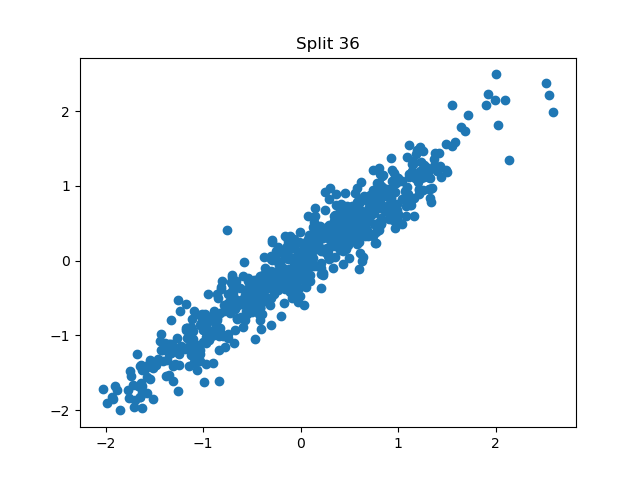

0.9549080229475961


<IPython.core.display.Javascript object>


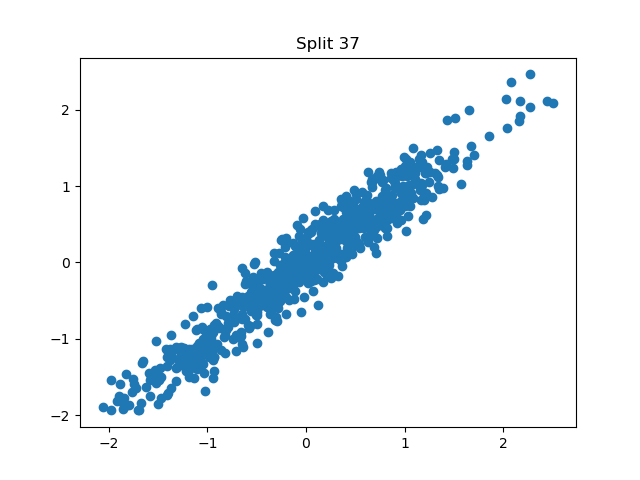

0.9565995601769958


<IPython.core.display.Javascript object>


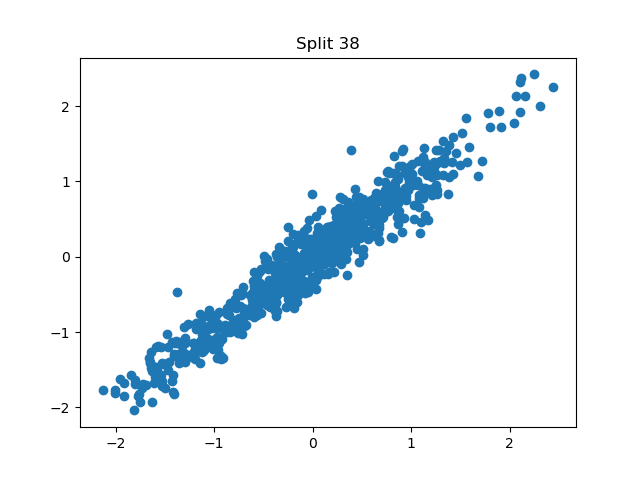

0.9554894853146404


<IPython.core.display.Javascript object>


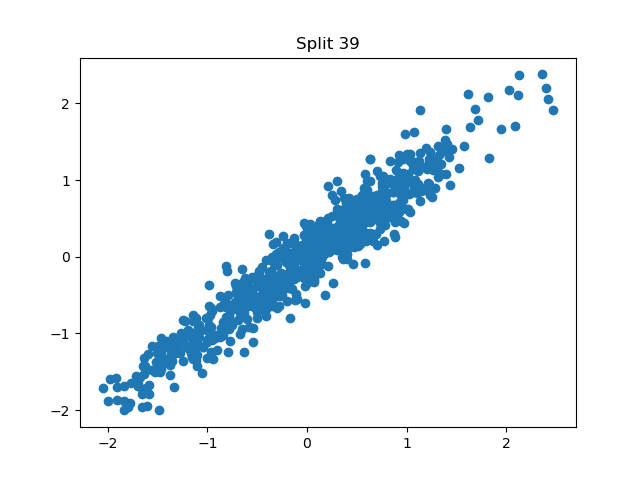

0.9593351241513317


<IPython.core.display.Javascript object>


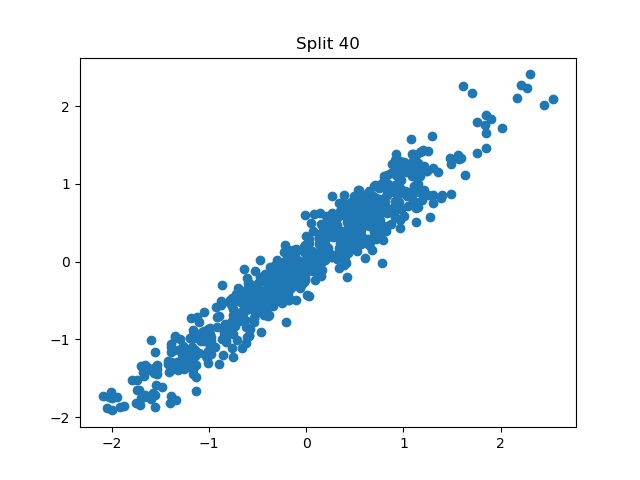

0.9509797528528938


<IPython.core.display.Javascript object>


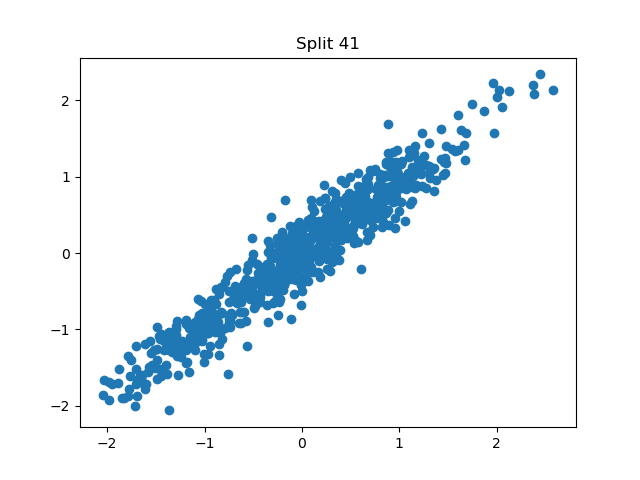

0.957149107820636


<IPython.core.display.Javascript object>


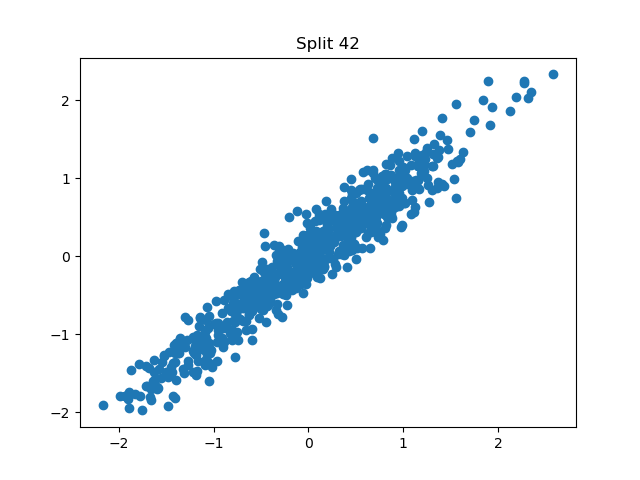

0.9563779775608489


<IPython.core.display.Javascript object>


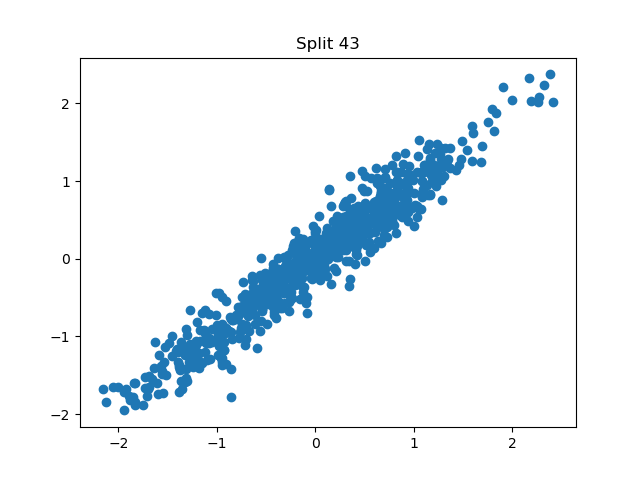

0.9533449410576729


<IPython.core.display.Javascript object>


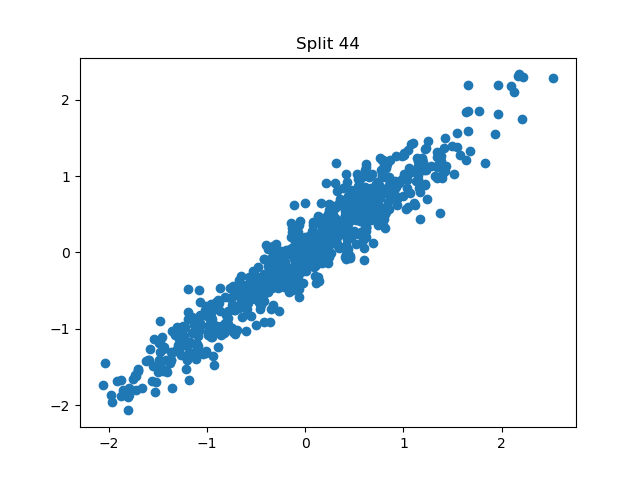

0.9550128693562121


<IPython.core.display.Javascript object>


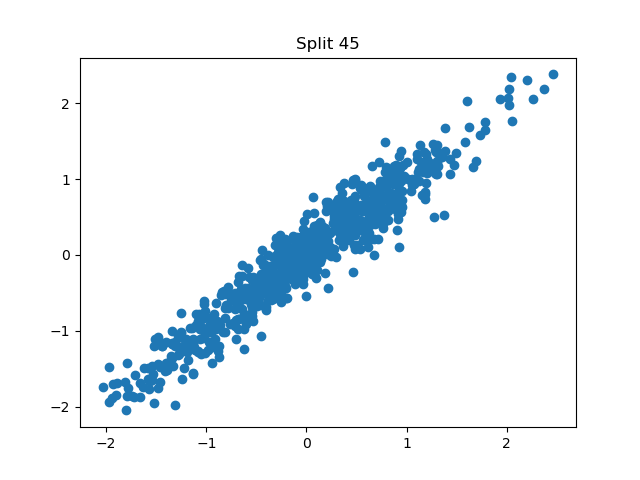

0.9570090755716898


<IPython.core.display.Javascript object>


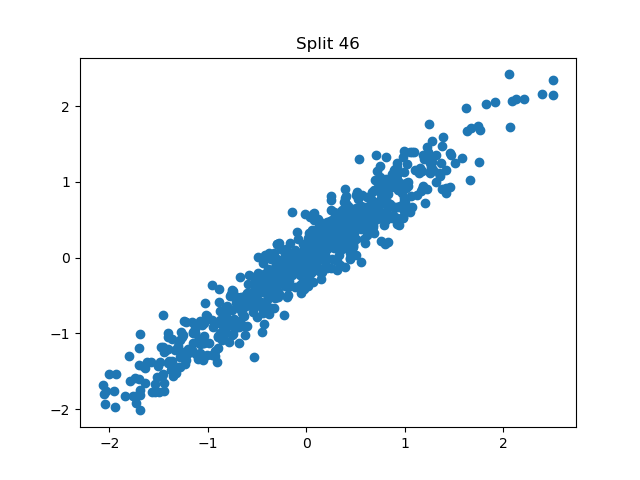

0.957533848060174


<IPython.core.display.Javascript object>


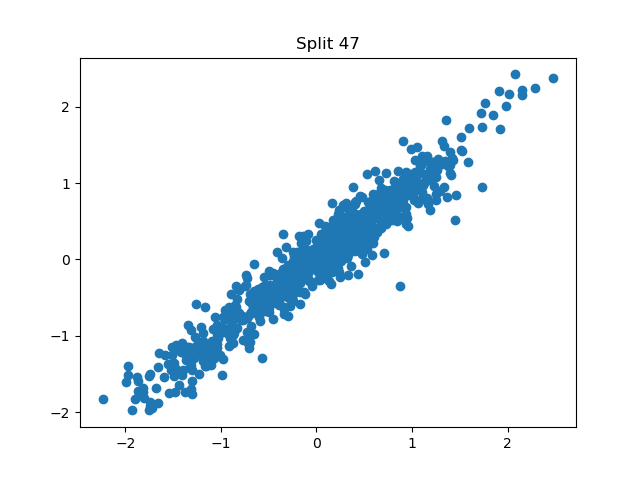

0.9560064924559865


<IPython.core.display.Javascript object>


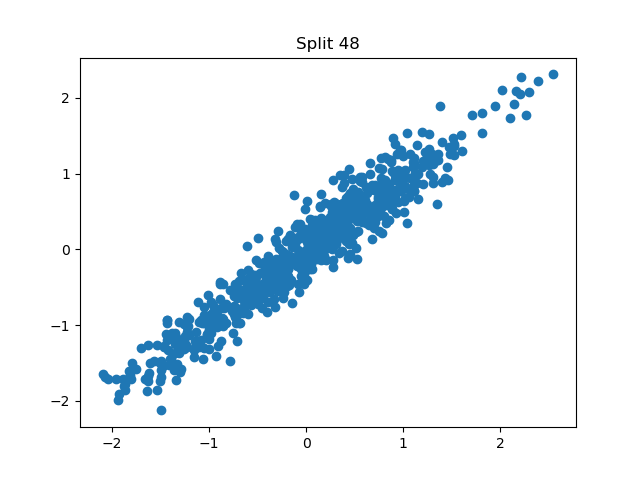

0.957245250213778


<IPython.core.display.Javascript object>


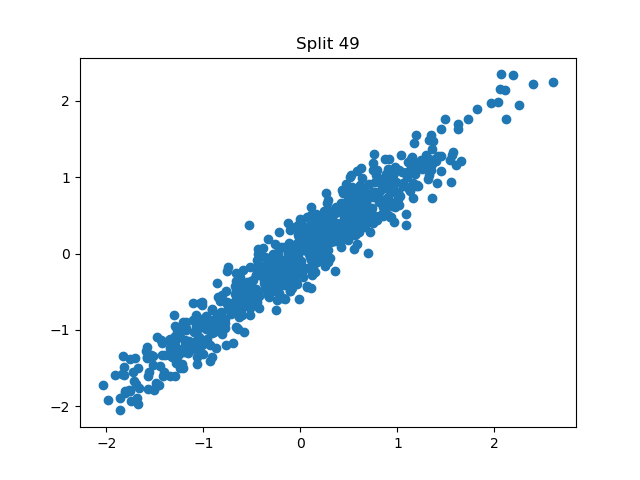

0.9578106414411403


<IPython.core.display.Javascript object>


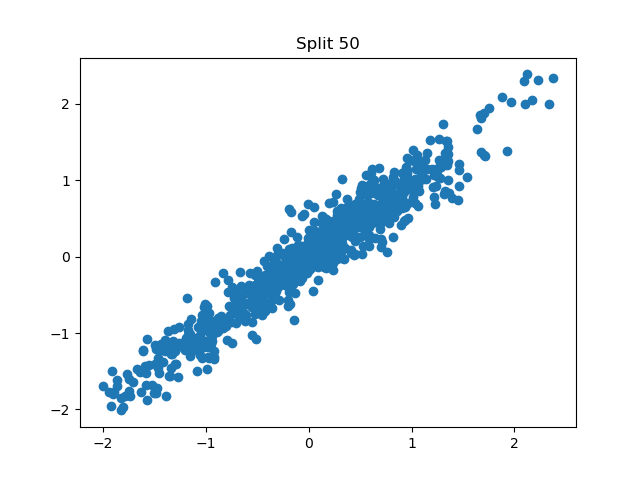

0.9568863091312161


<IPython.core.display.Javascript object>


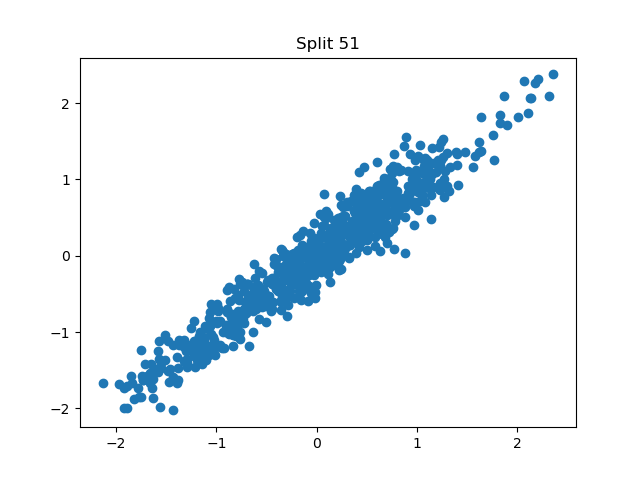

0.9569114256203121


<IPython.core.display.Javascript object>


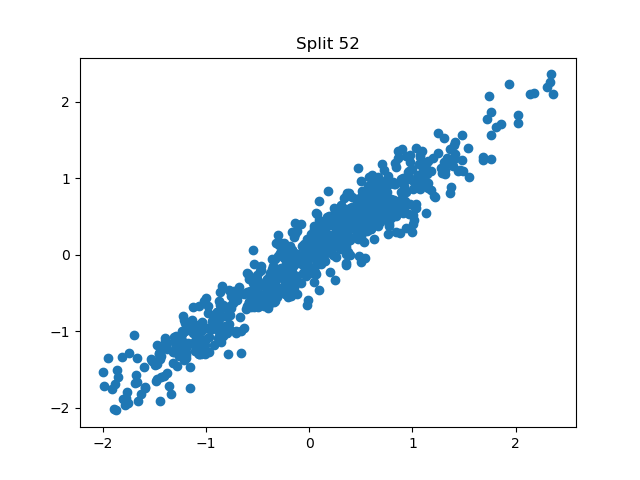

0.9554232096412616


<IPython.core.display.Javascript object>


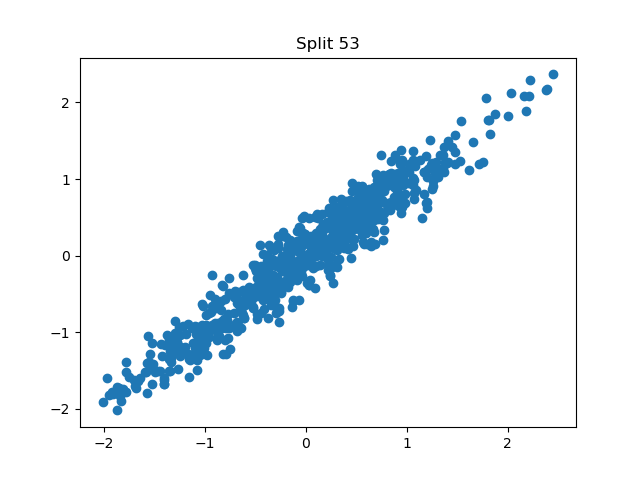

0.9527649578043692


<IPython.core.display.Javascript object>


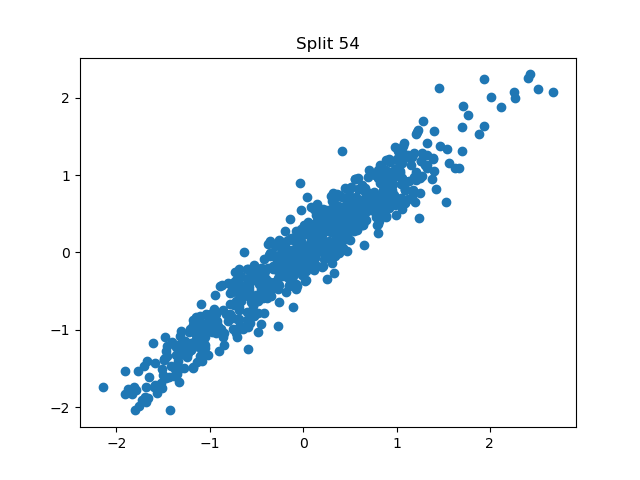

0.9551210153262494


<IPython.core.display.Javascript object>


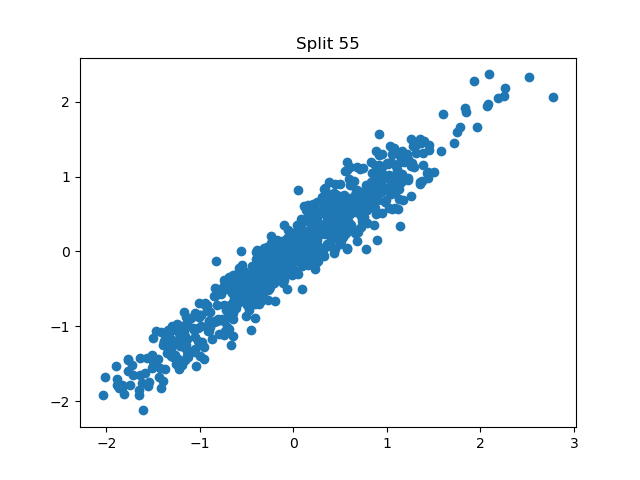

0.952869405990055


<IPython.core.display.Javascript object>


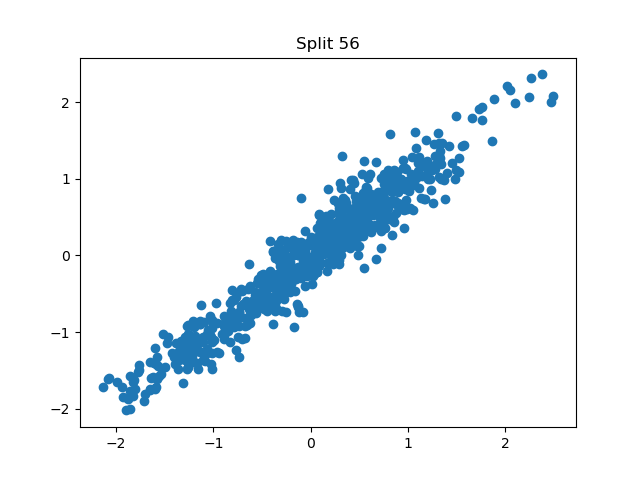

0.9560786276953381


<IPython.core.display.Javascript object>


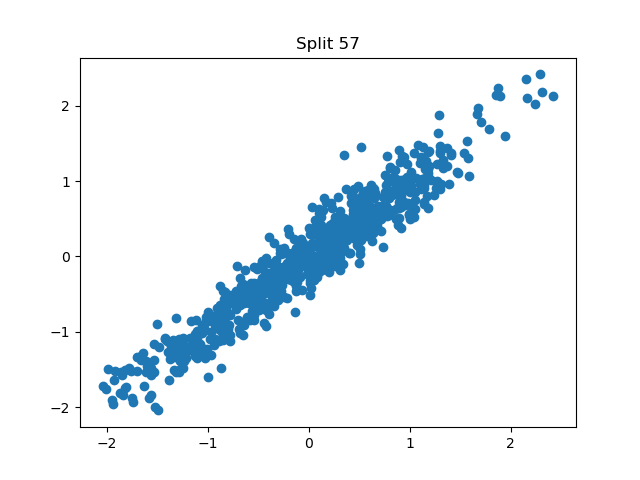

0.9566625362889533


<IPython.core.display.Javascript object>


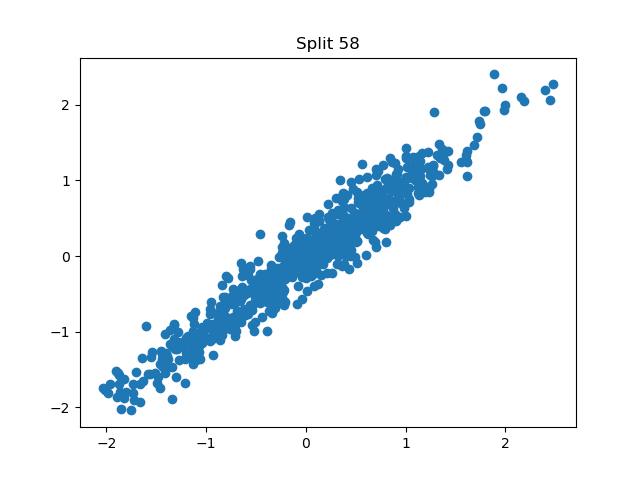

0.9524088327268135


<IPython.core.display.Javascript object>


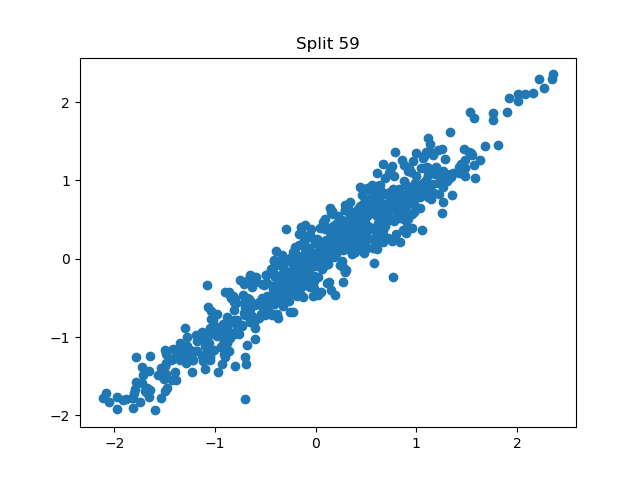

0.9596870394436255


<IPython.core.display.Javascript object>


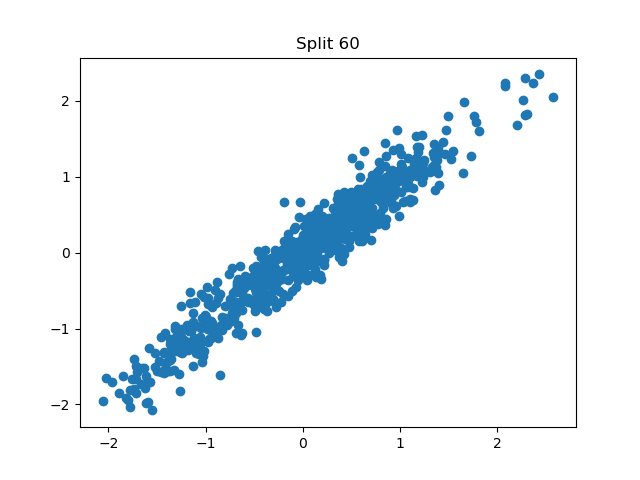

0.9561508482681746


<IPython.core.display.Javascript object>


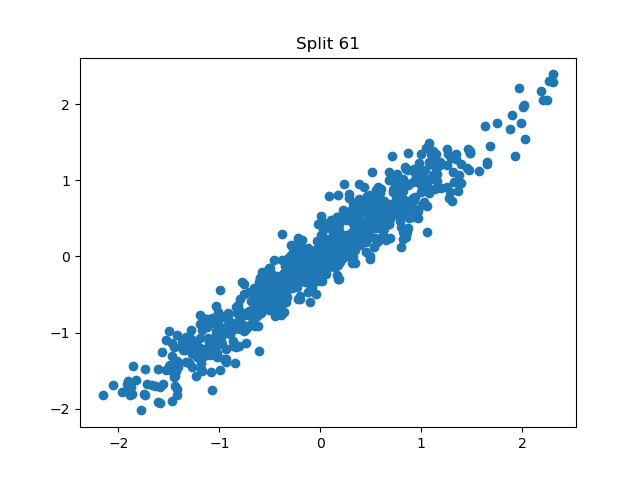

0.9567928405206052


<IPython.core.display.Javascript object>


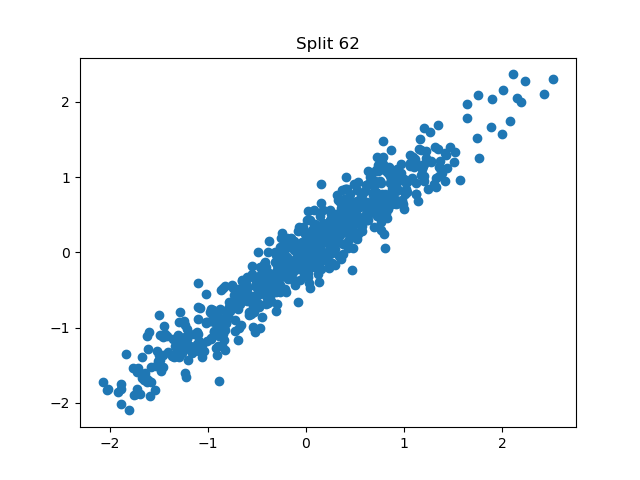

0.9537603160183394


<IPython.core.display.Javascript object>


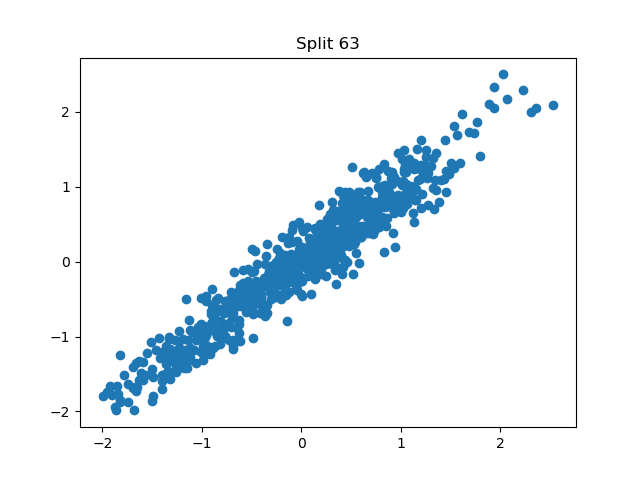

0.9554001696003014


<IPython.core.display.Javascript object>


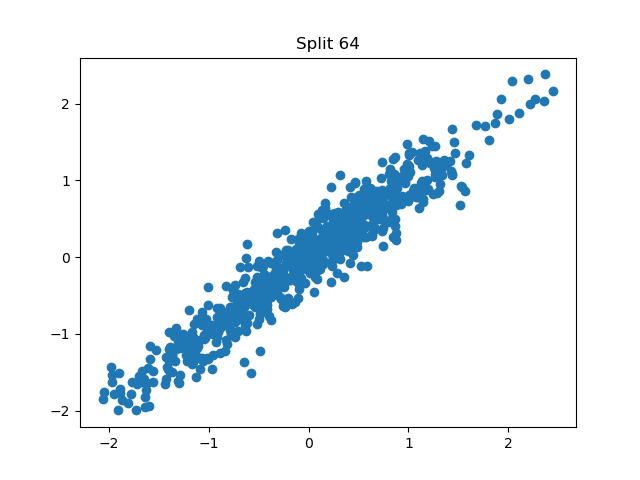

0.9546162962067487


<IPython.core.display.Javascript object>


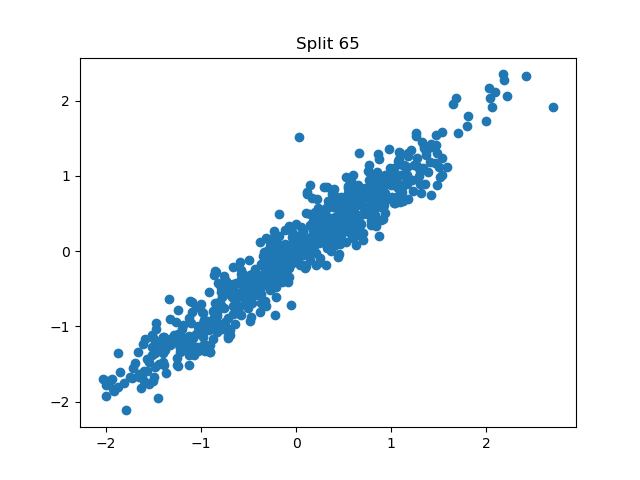

0.9569652994938656


<IPython.core.display.Javascript object>


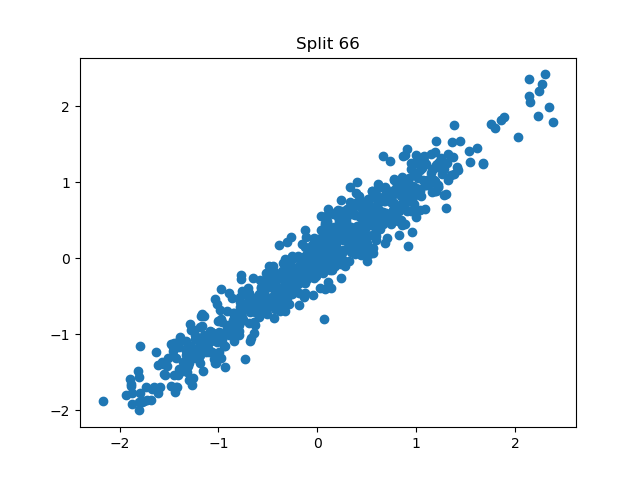

0.9570366951763467


<IPython.core.display.Javascript object>


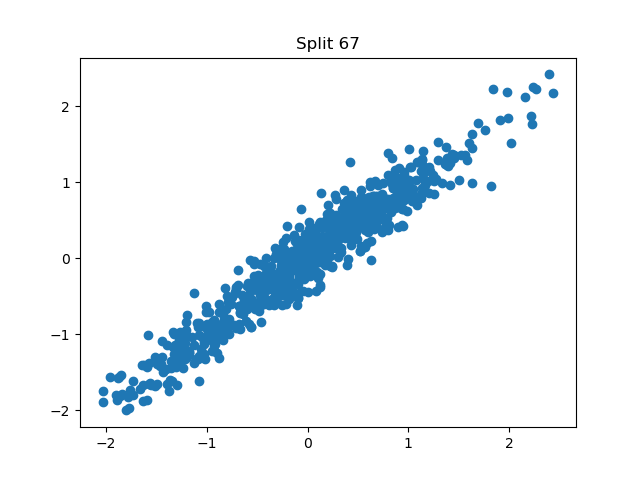

0.950939077225026


<IPython.core.display.Javascript object>


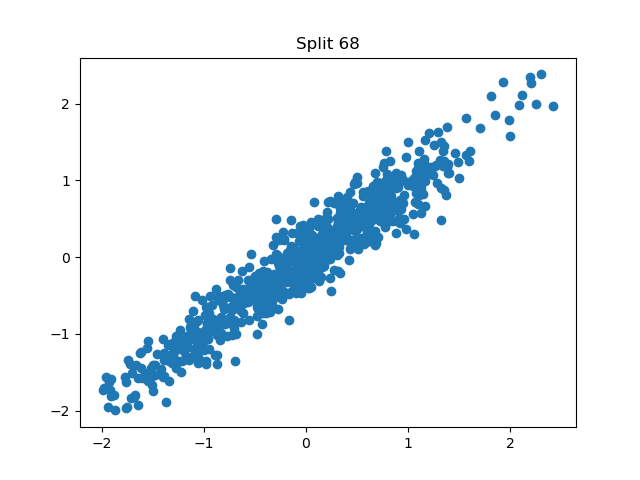

0.9601709940817672


<IPython.core.display.Javascript object>


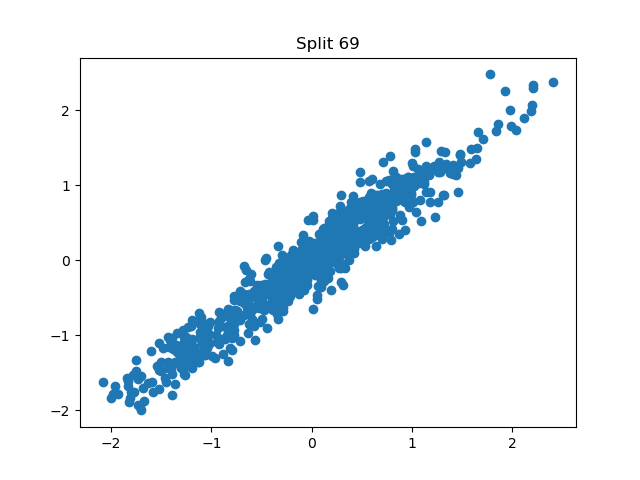

0.9504391083361925


<IPython.core.display.Javascript object>


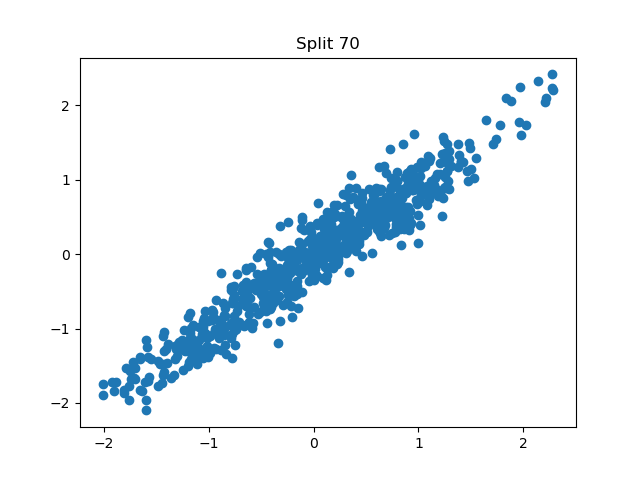

0.9549001153779828


<IPython.core.display.Javascript object>


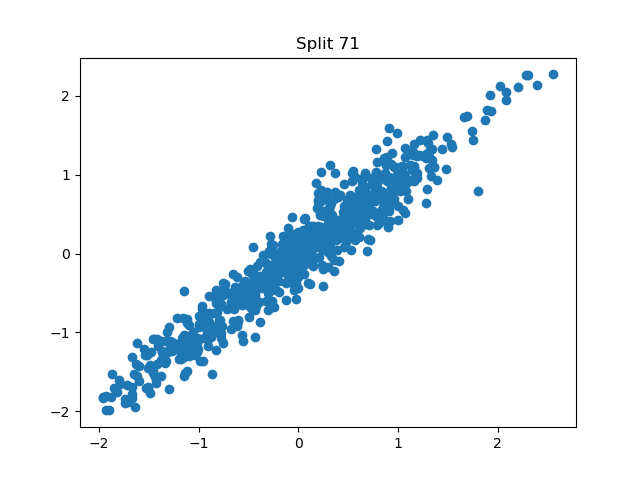

0.9577317933009657


<IPython.core.display.Javascript object>


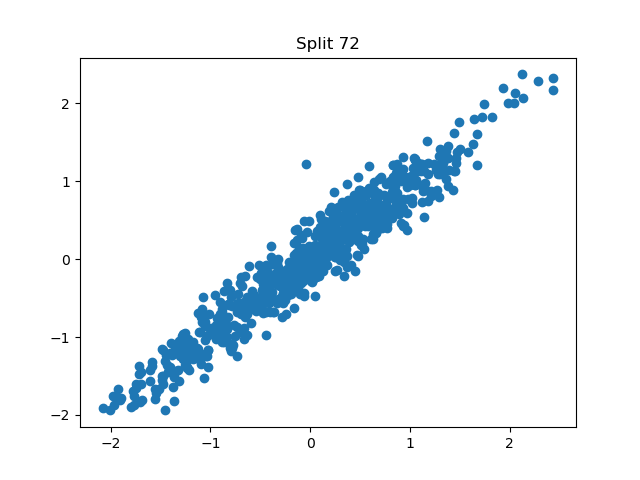

0.9515302676093644


<IPython.core.display.Javascript object>


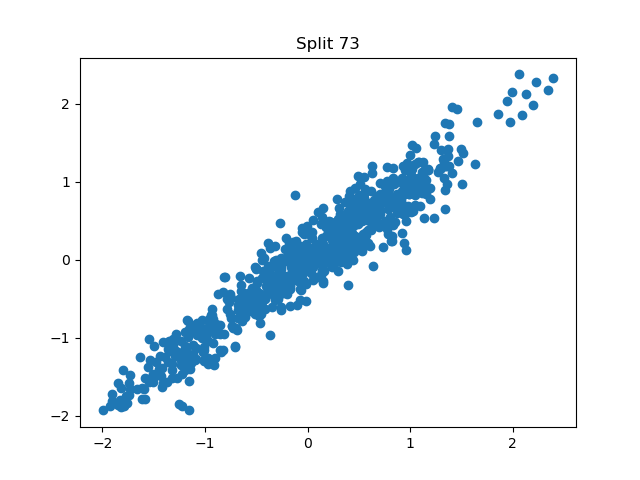

0.9595585556596544


<IPython.core.display.Javascript object>


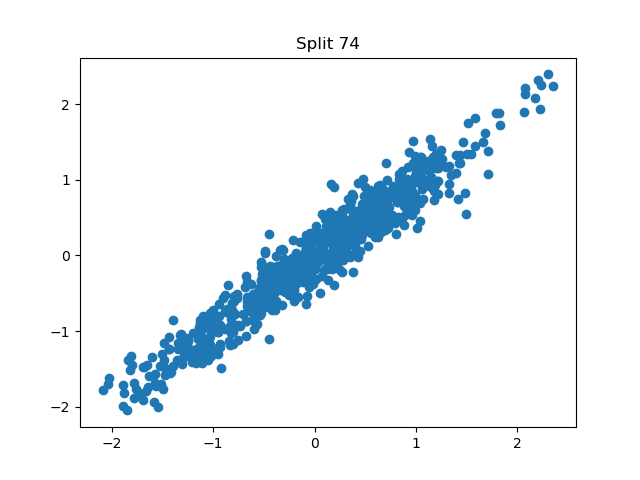

0.9587804849430841


<IPython.core.display.Javascript object>


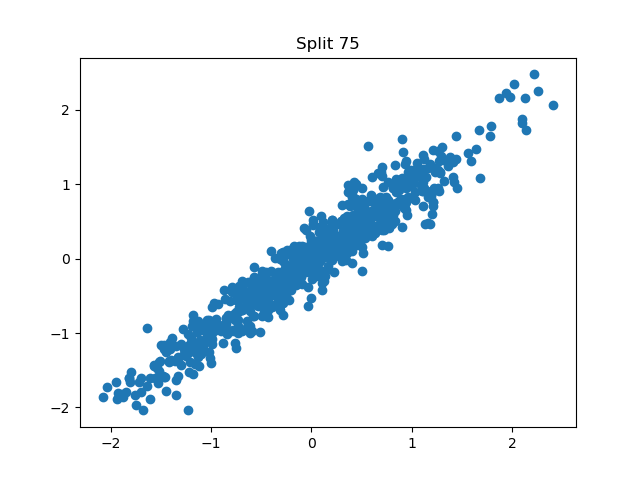

0.9555491618651765


<IPython.core.display.Javascript object>


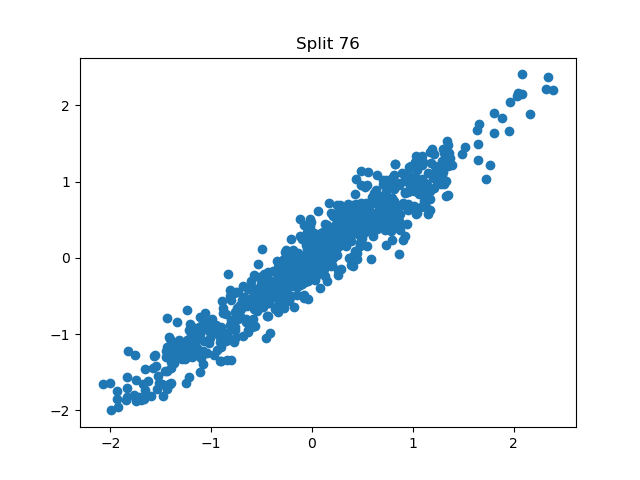

0.9550677103425961


<IPython.core.display.Javascript object>


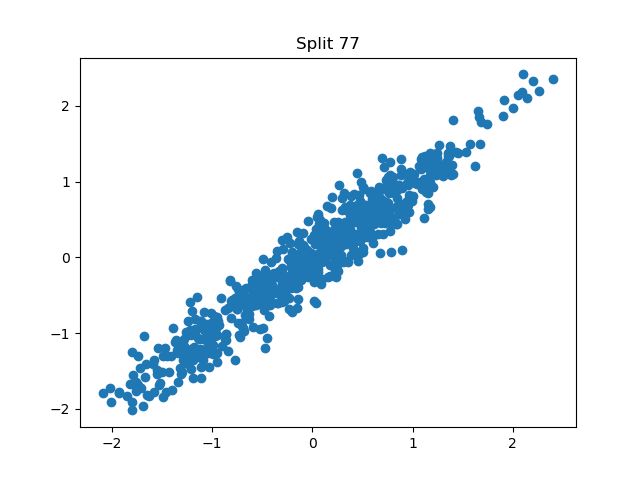

0.9567776796047636


<IPython.core.display.Javascript object>


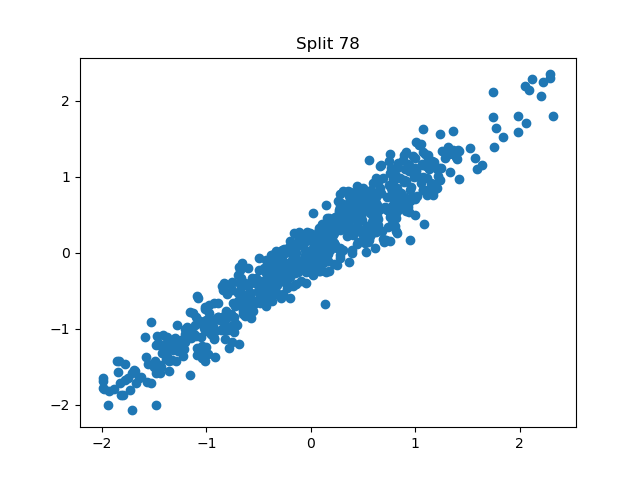

0.9583471046170747


<IPython.core.display.Javascript object>


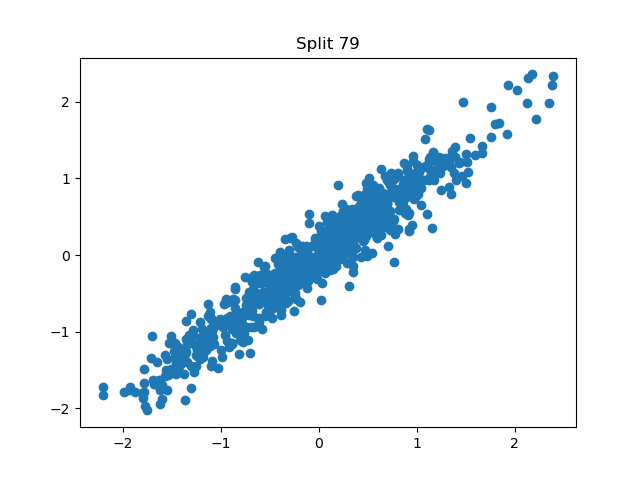

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.9572075897023816


<IPython.core.display.Javascript object>


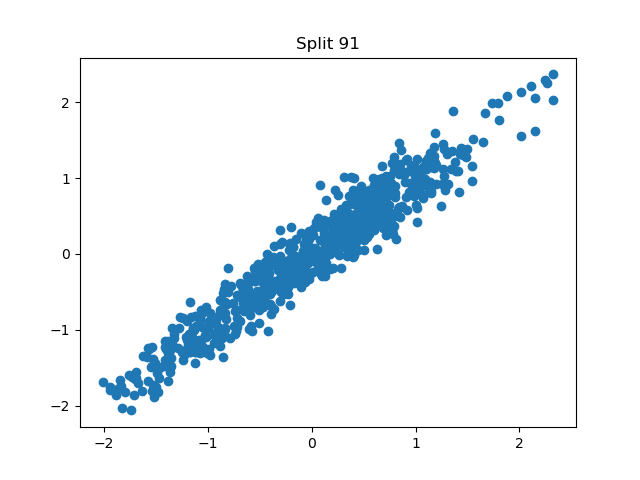

0.9533025303156094


<IPython.core.display.Javascript object>


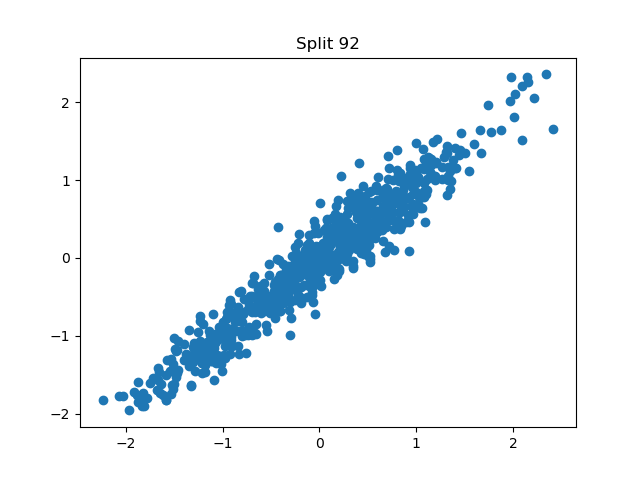

0.955920760748019


<IPython.core.display.Javascript object>


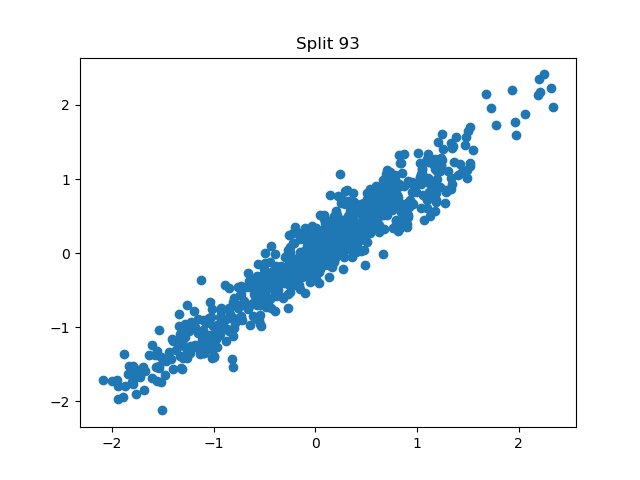

0.955527373381997


<IPython.core.display.Javascript object>


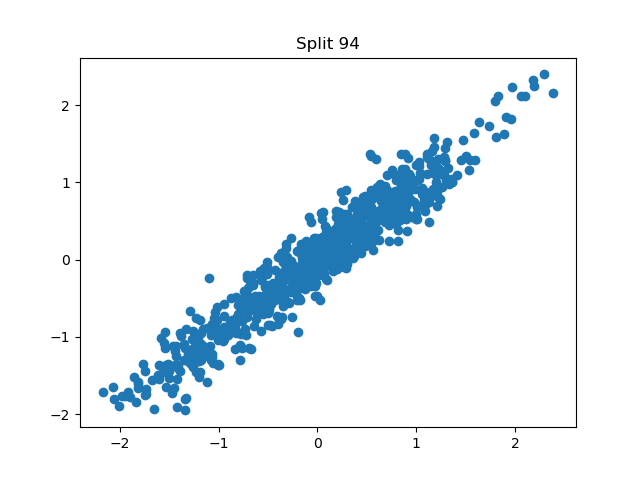

0.9574323865464649


<IPython.core.display.Javascript object>


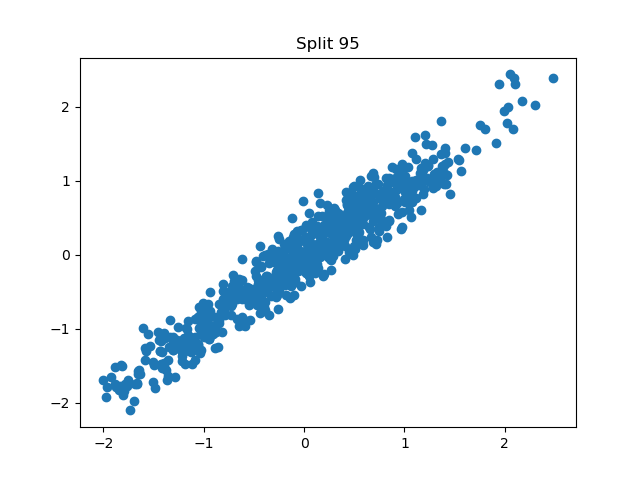

0.9599752675115866


<IPython.core.display.Javascript object>


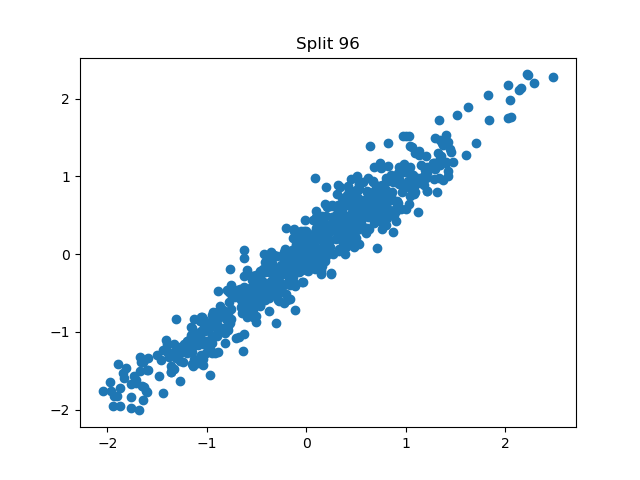

0.9550850614845536


<IPython.core.display.Javascript object>


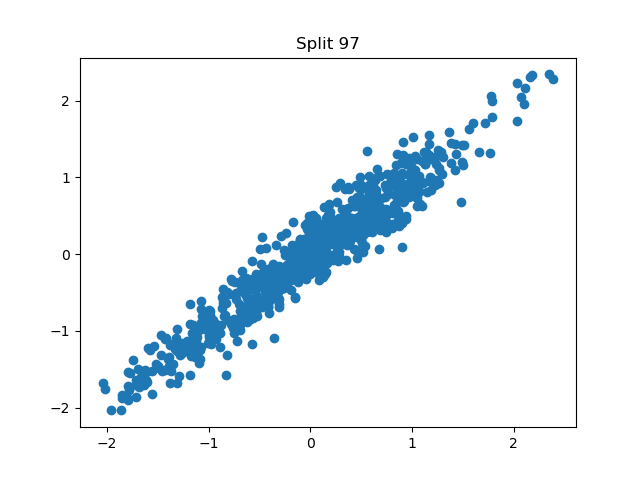

0.9519715555049876


<IPython.core.display.Javascript object>


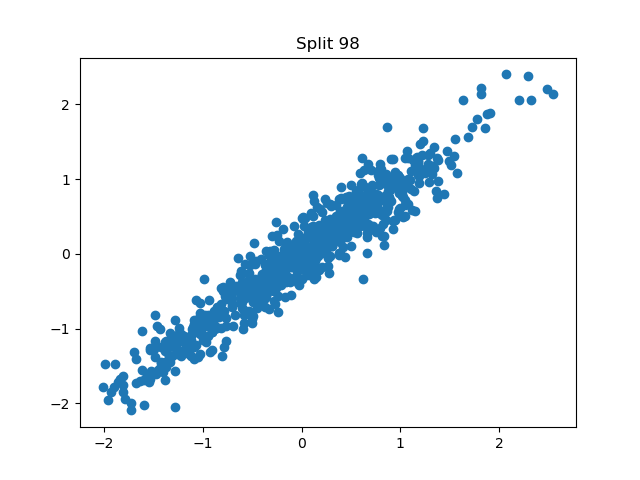

0.9493724397732262


<IPython.core.display.Javascript object>


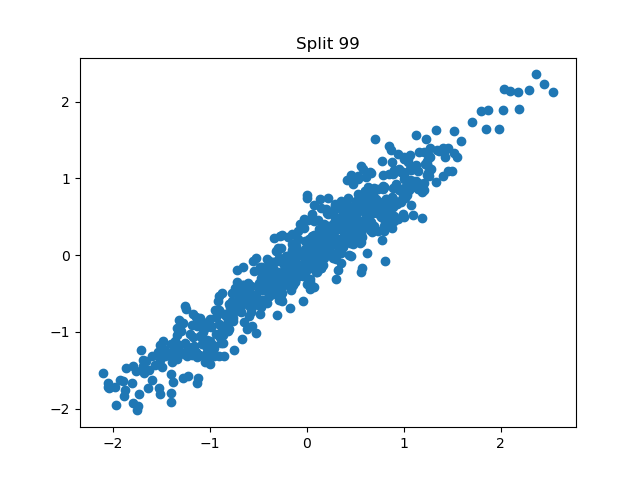

0.9559935217662607  is the median SROCC over 100 splits
0.002433688121044095  is the std. dev. of SROCC over 100 splits


In [18]:
%matplotlib notebook
from scipy.stats import spearmanr

scores = []
names = []
content = []
codec = []
fr = []
res = []
bitrate = [] 
srocc =[]

for rand_seed in range(100):
    np.random.seed(rand_seed)
    group1 = []
    group2 = []
    for key,val in video_dict.items():

        #if(len(val)<20):
        #    continue
        split_name = key.split('_')
        group1_indices = np.random.randint(low=0,high=len(val),size=len(val)//2)
        group2_indices = np.asarray(np.delete(np.arange(len(val)),group1_indices),dtype=int)

        group1_scores = np.asarray(val)[group1_indices]
        group2_scores = np.asarray(val)[group2_indices]
        group1.append(np.mean(group1_scores))
        group2.append(np.mean(group2_scores))
    group_srocc = spearmanr(group1,group2)
    print(group_srocc[0])
    srocc.append(group_srocc[0])
    plt.figure()
    plt.scatter(group1,group2)
    plt.title('Split '+str(rand_seed))
#    plt.savefig('./plots/internal_consistency/'+str(rand_seed)+'.png')
    plt.show()
    

print(np.median(srocc),' is the median SROCC over 100 splits')
print(np.std(srocc),' is the std. dev. of SROCC over 100 splits')